In [1]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as ss

def voltage_criterion(data=None, v_thresh=-40, time_thresh=260):
    threshold_crossings = np.diff(data > v_thresh, prepend=False)
    upward_crossings = np.argwhere(threshold_crossings)[::2,0]
    downward_crossings = np.argwhere(threshold_crossings)[1::2,0]
    # If length of threshold_crossings is not even
    if np.mod(np.argwhere(threshold_crossings).reshape(-1,).shape[0],2)!=0:
        legit_up_crossings = upward_crossings[:-1][np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
        legit_down_crossings = downward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
    else:
        legit_up_crossings = upward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
        legit_down_crossings = downward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
    return upward_crossings, legit_up_crossings, legit_down_crossings

# Input: upward and downward crossings
# Output: bounds of NMDA spikes meeting current criterion
def current_criterion(legit_uc_iso=[], legit_dc_iso=[], p=1, control_inmda=np.array([1])):
    bounds = []
    sum_current = []
    

    for ind1 in np.arange(0,len(legit_uc_iso)):
        e1 = control_inmda[legit_uc_iso[ind1], p] #current @ up_crossing[ind1]
        #all the indices where current crosses 130% of e1
        x30 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.3*e1, prepend=False))
        #all the indices where current crosses 115% of e1
        x15 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.15*e1, prepend=False))
        
        if len(x30)>0:
        
            x15_copy = x15
            x30_copy = x30
            
            try:
                i = x30[0][0]
            except:
                import pdb; pdb.set_trace()
                
            n = 0
            
            
            while n==0:
                if len(np.sort(x15[x15>i]))!=0:
                    b1 = i
                    b2 = np.sort(x15[x15>i])[0]
                    bounds.append([legit_uc_iso[ind1]+b1,legit_uc_iso[ind1]+b2])
                    sum_current.append(np.sum(control_inmda[legit_uc_iso[ind1]+b1:legit_uc_iso[ind1]+b2,p])/10)
                else:
                    b1 = i
                    b2 = (legit_dc_iso[ind1]-legit_uc_iso[ind1])
                    bounds.append([legit_uc_iso[ind1]+b1,legit_uc_iso[ind1]+b2])
                    sum_current.append(np.sum(control_inmda[legit_uc_iso[ind1]+b1:legit_uc_iso[ind1]+b2,p])/10)
                    n=1
                
                x30_copy = x30_copy[x30_copy>legit_uc_iso[ind1]+b2]
                #import pdb; pdb.set_trace()
                
                if len(x30_copy)!=0:
                    i = x30_copy[x30_copy>b2][0]
                else:
                    n=1
    return bounds, sum_current



In [2]:
output_folder = 'output_control'

conns = pd.read_csv('./{}/Connections.csv'.format(output_folder))

In [3]:
conns.loc[conns.Type=='dend','Sec ID'] = conns.loc[conns.Type=='dend','Name'].apply(lambda x: int(x.split('dend[')[1].split(']')[0]))
conns.loc[conns.Type=='apic','Sec ID'] = conns.loc[conns.Type=='apic','Name'].apply(lambda x: int(x.split('apic[')[1].split(']')[0]))
conns.loc[conns.Type=='soma','Sec ID'] = conns.loc[conns.Type=='soma','Name'].apply(lambda x: int(x.split('soma[')[1].split(']')[0]))
conns.loc[conns.Type=='axon','Sec ID'] = conns.loc[conns.Type=='axon','Name'].apply(lambda x: int(x.split('axon[')[1].split(']')[0]))

conns['X'] = conns['Name'].apply(lambda x: float(x.split('(')[1].split(')')[0]))

conns.rename(columns={'Distance':'conns_Distance'},inplace=True)

conns['Sec ID'] = conns['Sec ID'].astype(int)
conns['X'] = conns['X'].astype(float)

In [4]:
conns.head()

Node ID  conns_Distance  Conductance  Type  \
0        0       61.505696     0.500607  dend   
1        0      112.522057     0.325079  dend   
2        0       73.494480     0.554728  dend   
3        0      101.530468     1.005930  dend   
4        0       65.675576     0.304560  dend   

                                 Name Source Population  Release Probability  \
0  L5PCtemplate[0].dend[60](0.264706)          exc_stim                  0.6   
1  L5PCtemplate[0].dend[28](0.128571)          exc_stim                  0.6   
2       L5PCtemplate[0].dend[29](0.7)          exc_stim                  0.6   
3  L5PCtemplate[0].dend[33](0.264706)          exc_stim                  0.6   
4  L5PCtemplate[0].dend[48](0.409091)          exc_stim                  0.6   

   Sec ID         X  
0      60  0.264706  
1      28  0.128571  
2      29  0.700000  
3      33  0.264706  
4      48  0.409091

In [5]:
segs = pd.read_csv('/Volumes/TOSHIBA EXT/L5NeuronSimulation_new/L5NeuronSimulation/MorphAnalysis/Segments.csv')
segs_degrees = pd.read_csv('SegmentsDegrees.csv').groupby(['Type','Sec ID'])['Degrees'].max().reset_index()
segs['segmentID'] = segs.index
segs = segs.set_index(['Type','Sec ID']).join(segs_degrees.set_index(['Type','Sec ID'])).reset_index()

segs['Sec ID'] = segs['Sec ID'].astype(int)
segs['X'] = segs['X'].astype(float)
segs['Elec_distanceQ'] = 'None'

segs.loc[segs.Type=='dend','Elec_distanceQ'] = pd.qcut(segs.loc[segs.Type=='dend','Elec_distance'], 10, labels=False)
segs.loc[segs.Type=='apic','Elec_distanceQ'] = pd.qcut(segs.loc[segs.Type=='apic','Elec_distance'], 10, labels=False)

In [15]:
exc_syns_per_seg = conns[conns['Source Population']=='exc_stim'].groupby(['Type','Sec ID','X'])['Conductance'].count().reset_index().rename(columns={'Conductance':'num_syns'})

inh_conns = conns[(conns['Source Population']=='dist_inh_stim')|
                  (conns['Source Population']=='prox_inh_stim')].sort_values(by=['Type','Sec ID','X']).reset_index(drop=True)
inh_syns_per_seg = inh_conns.groupby(['Type','Sec ID','X'])['Conductance'].count().reset_index().rename(columns={'Conductance':'num_syns'})

segs['segmentID'] = segs.groupby(['Type','Sec ID']).cumcount()+1

exc_syns_per_seg['segmentID'] = exc_syns_per_seg.groupby(['Type','Sec ID']).cumcount()+1
inh_syns_per_seg['segmentID'] = inh_syns_per_seg.groupby(['Type','Sec ID']).cumcount()+1

exc_syns = segs.set_index(['Type','Sec ID','segmentID']).join(exc_syns_per_seg[['Type','Sec ID','segmentID','num_syns']].set_index(['Type','Sec ID','segmentID'])).reset_index()
inh_syns = segs.set_index(['Type','Sec ID','segmentID']).join(inh_syns_per_seg[['Type','Sec ID','segmentID','num_syns']].set_index(['Type','Sec ID','segmentID'])).reset_index()



In [20]:
exc_syns[exc_syns.Type=='apic']['num_syns'].sum() / exc_syns[exc_syns.Type=='apic']['Section_L'].unique().sum()

2.1647901629711943

In [21]:
exc_syns[exc_syns.Type=='dend']['num_syns'].sum() / exc_syns[exc_syns.Type=='dend']['Section_L'].unique().sum()

1.967666458778837

In [6]:
v = h5py.File('./{}/v_report.h5'.format(output_folder),'r')
hva = h5py.File('./{}/Ca_HVA.ica_report.h5'.format(output_folder),'r')
lva = h5py.File('./{}/Ca_LVAst.ica_report.h5'.format(output_folder),'r')
ih = h5py.File('./{}/Ih.ihcn_report.h5'.format(output_folder),'r')

nmda = h5py.File('./{}/inmda_report.h5'.format(output_folder),'r')

na = h5py.File('./{}/NaTa_t.gNaTa_t_report.h5'.format(output_folder),'r')
spks = h5py.File('./{}/spikes.h5'.format(output_folder),'r')

In [7]:
spktimes = spks['spikes']['biophysical']['timestamps'][:]
spkinds = np.sort((spktimes*10).astype(int))

In [8]:
na_df = pd.DataFrame(columns=['segmentID','na_lower_bound'])

for p in segs[(segs.Type=='dend')|(segs.Type=='apic')].index:
    print(p)
    threshold_crossings = np.diff(na['report']['biophysical']['data'][:,p] > 0.003, prepend=False)
    upward_crossings = np.argwhere(threshold_crossings)[::2,0]
    downward_crossings = np.argwhere(threshold_crossings)[1::2,0]
    # Only count if not within 2 ms after a somatic spike
    na_spks = [i for i in upward_crossings if ~np.any((i-spkinds>=-5) & (i-spkinds<50))]
    
    if len(na_spks)>0:
        na_df = na_df.append(pd.DataFrame({'segmentID':np.tile(p,len(na_spks)),
                                               'na_lower_bound':na_spks}))
    else:
        na_df = na_df.append(pd.DataFrame({'segmentID':p,
                                               'na_lower_bound':np.array([np.nan])}))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


2513
2514
2515
2516
2517
2518
2519
2520


In [9]:
na_df.reset_index(inplace=True)

In [12]:
na_df.to_csv('na_df.csv',index=False)

In [10]:
def reshape_pad(v, fillval=np.nan):
    lens = np.array([len(item) for item in v])
    mask = lens[:,None] > np.arange(lens.max())
    out = np.full(mask.shape,fillval)
    out[mask] = np.concatenate(v)
    return out

In [11]:
# get the value of the conductance at the peak
df = pd.DataFrame(columns=['segmentID','na_lower_bound','peak_value'])

for s in na_df[~pd.isnull(na_df.na_lower_bound)].segmentID.unique():

    inds = na_df[na_df.segmentID==s]['na_lower_bound'].astype(int).values
    
    L = np.split(na['report']['biophysical']['data'][:,s], inds)
    
    X = reshape_pad(L)
    
    peak_vals = np.max(X[:,0:10], axis=1)
    
    df = pd.concat((df,pd.DataFrame({'segmentID': s*np.ones((inds.shape[0],)).astype(int),
                                     'na_lower_bound': inds, 
                                     'peak_value': peak_vals[1:]})))
    
    print(s)

0
1
2
3
4
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
220
221
222
223
224
225
226
246
247
248
250
251
252
253
254
255
256
257
258
259
260
261
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324

KeyboardInterrupt: 

In [ ]:
df.head()

In [ ]:
df.groupby('segmentID')['peak_value'].mean().hist()

In [134]:
df_gb = df.groupby('segmentID')['na_lower_bound'].count().sort_values().reset_index()

In [139]:
outliers = df_gb[df_gb.na_lower_bound>1000]['segmentID'].values

In [165]:
df_noout = df[(df.segmentID.isin(outliers))&(df.peak_value>0.006)]

In [171]:
na_df_new = pd.concat((df_noout[['segmentID','na_lower_bound','peak_value']],
                       na_df.loc[~na_df.segmentID.isin(outliers),['segmentID','na_lower_bound','peak_value']]))

In [174]:
na_df_new.to_csv('na_df.csv',index=False)

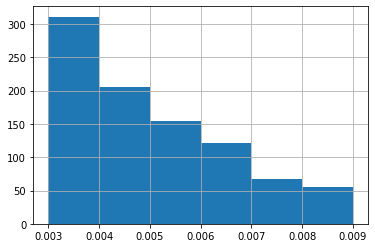

In [149]:
df.loc[df.segmentID==936,'peak_value'].hist(bins=np.arange(0.003,0.01,0.001))

In [24]:
#for i in na_df.segmentID.unique():
#    seg = na_df.loc[i,'segmentID']
#    if not pd.isnull(na_df.loc[i,'na_lower_bound']):
#        spkt = int(na_df.loc[i,'na_lower_bound'])
#        trace = na['report']['biophysical']['data'][spkt-10:spkt+10,seg]
#        peak_value = np.max(trace)
#        half_peak = peak_value/2
#        duration = np.arange(0,20)[trace>half_peak] + spkt - 10
#        na_df.loc[i,'duration_low'] = duration[0]
#        na_df.loc[i,'duration_high'] = duration[-1]
#        na_df.loc[i,'peak_value'] = peak_value
#    else:
#        na_df.loc[i,'duration_low'] = np.nan
#        na_df.loc[i,'duration_high'] = np.nan
#        na_df.loc[i,'peak_value'] = np.nan
#        
#na_df['duration'] = (na_df['duration_high'] - na_df['duration_low'] + 1)/10

KeyboardInterrupt: 

In [64]:
#na_df.to_csv('64Hz_soma_inh_na_df.csv')
#na_df = pd.read_csv('na_df.csv')

## Plot example events

In [14]:
na_df[na_df.segmentID==101].sort_values(by='na_lower_bound').head()

Unnamed: 0  segmentID  na_lower_bound
34965           0        101           976.0
34966           1        101          1122.0
34967           2        101          1846.0
34968           3        101          5325.0
34969           4        101          5521.0

In [15]:
ina = h5py.File('./output/NaTa_t.ina_report.h5','r')

In [16]:
np.median(ina['report']['biophysical']['data'][:,101])

-0.00017846864685736784

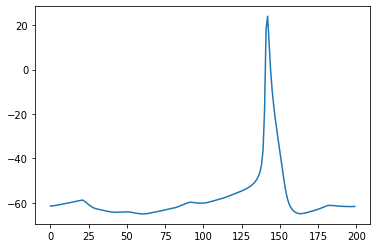

In [17]:
plt.plot(v['report']['biophysical']['data'][8500:8700,0])

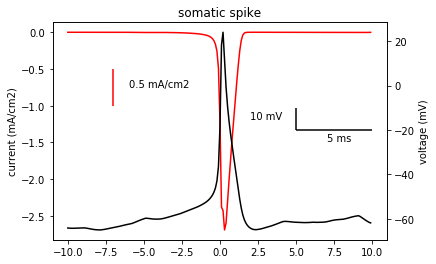

In [18]:
t = 8640
plt.plot(np.arange(-10,10,.1), (v['report']['biophysical']['data'][t-100:t+100,0]-45)*na['report']['biophysical']['data'][t-100:t+100,0],color='r')
plt.vlines(-7,-0.5,-1,color='r')
#plt.hlines(0,-10,10,color='r',linestyle='dashed',alpha=0.2)
plt.text(-6,-0.75,'0.5 mA/cm2')
plt.ylabel('current (mA/cm2)')

plt.twinx()
plt.plot(np.arange(-10,10,.1), v['report']['biophysical']['data'][t-100:t+100,0],color='k')
plt.vlines(5,-10,-20,color='k')
plt.hlines(-20,5,10,color='k')
#plt.hlines(-60,-10,10,color='k',linestyle='dashed',alpha=0.2)
#plt.text(10,-60,'-60 mV')
plt.ylabel('voltage (mV)')
plt.text(7,-25,'5 ms')
plt.text(2,-15,'10 mV')
plt.title('somatic spike')

plt.savefig('exSomaspike.svg')

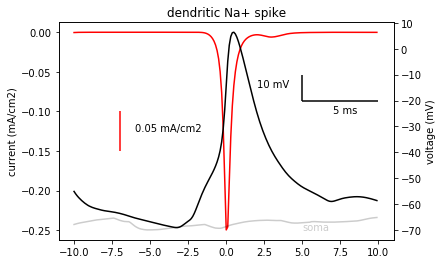

In [22]:
t = 5325
plt.plot(np.arange(-10,10,.1), (v['report']['biophysical']['data'][t-100:t+100,101]-45)*na['report']['biophysical']['data'][t-100:t+100,101],color='r')
plt.vlines(-7,-0.1,-0.15,color='r')
#plt.hlines(0,-10,10,color='r',linestyle='dashed',alpha=0.2)
plt.text(-6,-0.125,'0.05 mA/cm2')
plt.ylabel('current (mA/cm2)')

plt.twinx()
plt.plot(np.arange(-10,10,.1), v['report']['biophysical']['data'][t-100:t+100,101],color='k')
plt.plot(np.arange(-10,10,.1), v['report']['biophysical']['data'][t-100:t+100,0],color='k',alpha=0.2)
plt.text(5,-70,'soma',alpha=0.2)
plt.vlines(5,-10,-20,color='k')
plt.hlines(-20,5,10,color='k')
#plt.hlines(-60,-10,10,color='k',linestyle='dashed',alpha=0.2)
#plt.text(10,-60,'-60 mV')
plt.ylabel('voltage (mV)')
plt.text(7,-25,'5 ms')
plt.text(2,-15,'10 mV')
plt.title('dendritic Na+ spike')

plt.savefig('exNaspike.svg')

In [25]:
nmda_df = pd.read_csv('nmda_df.csv')

In [26]:
nmda_df['duration'] = nmda_df['nmda_upper_bound'] - nmda_df['nmda_lower_bound']

In [27]:
p = np.random.choice(nmda_df[(~pd.isnull(nmda_df.nmda_lower_bound))&(nmda_df.duration<300)].index)
nmda_df.loc[p,'segmentID'], nmda_df.loc[p,'nmda_lower_bound']

(76, 643309.0)

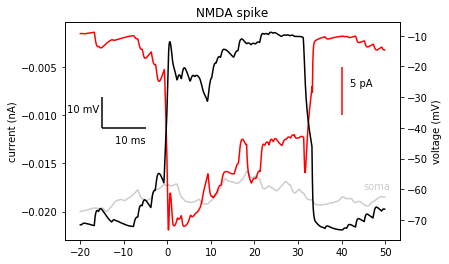

In [52]:
t = 643309
s = 76

plt.plot(np.arange(-20,50,.1),nmda['report']['biophysical']['data'][t-200:t+500,s],color='r')
plt.vlines(40,-0.005,-0.01,color='r')
plt.text(42,-0.007,'5 pA')
plt.ylabel('current (nA)')

plt.twinx()

plt.plot(np.arange(-20,50,.1),v['report']['biophysical']['data'][t-200:t+500,s],color='k')
plt.plot(np.arange(-20,50,.1),v['report']['biophysical']['data'][t-200:t+500,0],color='k',alpha=0.2)
plt.text(45,-60,'soma',alpha=0.2)
plt.hlines(-40,-15,-5)
plt.vlines(-15,-30,-40)
plt.text(-23,-35,'10 mV')
plt.text(-12,-45,'10 ms')
plt.ylabel('voltage (mV)')
plt.title('NMDA spike')
plt.savefig('NMDAspike.svg')

In [160]:
ca_df = pd.read_csv('ca_df.csv')

In [161]:
p = np.random.choice(ca_df[(~pd.isnull(ca_df.ca_lower_bound))].index)
ca_df.loc[p,'segmentID'], ca_df.loc[p,'ca_lower_bound']

(1511, 1056520)

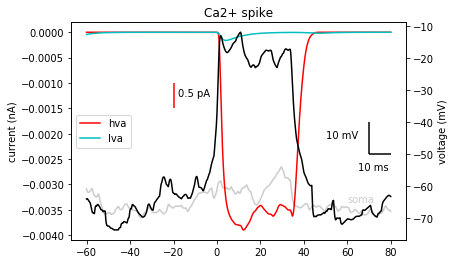

In [166]:
t = 1090075
s = 1312

plt.plot(np.arange(-60,80,.1),hva['report']['biophysical']['data'][t-600:t+800,s],color='r',label='hva')
plt.plot(np.arange(-60,80,.1),lva['report']['biophysical']['data'][t-600:t+800,s],color='c',label='lva')
plt.legend(loc='center left')
plt.vlines(-20,-0.001,-0.0015,color='r')
plt.text(-18,-0.00125,'0.5 pA')
plt.ylabel('current (nA)')

plt.twinx()

plt.plot(np.arange(-60,80,.1),v['report']['biophysical']['data'][t-600:t+800,s],color='k')
plt.plot(np.arange(-60,80,.1),v['report']['biophysical']['data'][t-600:t+800,0],color='k',alpha=0.2)
plt.hlines(-50,70,80)
plt.text(65,-55,'10 ms')
plt.vlines(70,-40,-50)
plt.text(50,-45,'10 mV')
plt.ylabel('voltage (mV)')
plt.title('Ca2+ spike')
plt.text(60,-65,'soma',alpha=0.2)
plt.savefig('Caspike.svg')

In [121]:
for i in np.random.choice(na_df[(na_df.na_lower_bound>20) & (na_df.na_lower_bound<1400000)].index,10000):
    seg = na_df.loc[i,'segmentID']
    if not pd.isnull(na_df.loc[i,'na_lower_bound']):
        spkt = int(na_df.loc[i,'na_lower_bound'])
        trace = na['report']['biophysical']['data'][spkt-10:spkt+10,seg]
        peak_value = np.max(trace)
        half_peak = peak_value/2
        duration = np.arange(0,20)[trace>half_peak] + spkt - 10
        na_df.loc[i,'duration_low'] = duration[0]
        na_df.loc[i,'duration_high'] = duration[-1]
        na_df.loc[i,'peak_value'] = peak_value
    else:
        na_df.loc[i,'duration_low'] = np.nan
        na_df.loc[i,'duration_high'] = np.nan
        na_df.loc[i,'peak_value'] = np.nan

In [126]:
na_df['duration'] = (na_df['duration_high'] - na_df['duration_low'] + 1)/10

In [175]:
na_df = pd.read_csv('na_df.csv')

In [176]:
segs_na_df = segs.set_index('segmentID').join(na_df.set_index('segmentID')).reset_index()

In [177]:
def get_sta(segs_na_df, spktimes):
    na_dend = np.zeros((10,39,))
    na_apic = np.zeros((10,39,))
    
    edges_dend=np.quantile(segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                       (segs_na_df.Type=='dend')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    
    edges_apic=np.quantile(segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                       (segs_na_df.Type=='apic')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    
    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                na_inds = segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                     (segs_na_df.Type=='dend')&
                                     (segs_na_df.Elec_distance>edges_dend[e])&
                                     (segs_na_df.Elec_distance<=edges_dend[e+1])]['na_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(na_inds/10,bins=np.arange(np.floor(i)-20,np.floor(i)+20,1))
                na_dend[e] += x2
                
                na_inds = segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                     (segs_na_df.Type=='apic')&
                                     (segs_na_df.Elec_distance>edges_apic[e])&
                                     (segs_na_df.Elec_distance<=edges_apic[e+1])]['na_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(na_inds/10,bins=np.arange(np.floor(i)-20,np.floor(i)+20,1))
                na_apic[e] += x2
            
            actual_spktimes.append(i)
        c = i
    return na_dend, na_apic

In [178]:
na_dend, na_apic = get_sta(segs_na_df, spktimes)
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spktimes.shape[0]))
na_dend_rand, na_apic_rand = get_sta(segs_na_df, rand_spktimes)

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Na spikes - apical')
plt.imshow((na_apic-na_apic_rand)/len(spktimes),cmap='jet',vmin=-0.5)
plt.colorbar(label='additional events per AP')
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.xlim(5,35)

plt.subplot(2,1,2)
plt.title('Na spikes - basal')
plt.imshow((na_dend-na_dend_rand)/len(spktimes),cmap='jet',vmin=-0.2, vmax=0.2)
plt.colorbar(label='additional events per AP')
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.xlabel('time(ms)')
plt.xlim(5,35)
plt.savefig('naspikes.svg')
plt.show()


----------

In [133]:
segs = pd.read_csv('/Volumes/TOSHIBA EXT/L5NeuronSimulation_new/L5NeuronSimulation/MorphAnalysis/Segments.csv')
segs_degrees = pd.read_csv('SegmentsDegrees.csv').groupby(['Type','Sec ID'])['Degrees'].max().reset_index()
segs['segmentID'] = segs.index
segs = segs.set_index(['Type','Sec ID']).join(segs_degrees.set_index(['Type','Sec ID'])).reset_index()

segs['Sec ID'] = segs['Sec ID'].astype(int)
segs['X'] = segs['X'].astype(float)
segs['Elec_distanceQ'] = 'None'

segs.loc[segs.Type=='dend','Elec_distanceQ'] = pd.qcut(segs.loc[segs.Type=='dend','Elec_distance'], 10, labels=False)
segs.loc[segs.Type=='apic','Elec_distanceQ'] = pd.qcut(segs.loc[segs.Type=='apic','Elec_distance'], 10, labels=False)

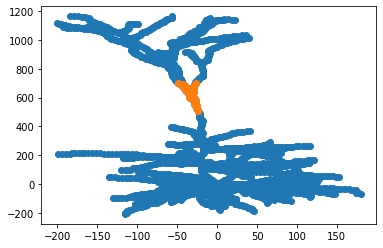

In [14]:
plt.scatter(segs['Coord X'], segs['Coord Y'])
plt.scatter(segs.loc[(segs['Coord Y']>500) & (segs['Coord Y']<700),'Coord X'],
            segs.loc[(segs['Coord Y']>500) & (segs['Coord Y']<700),'Coord Y'])

# Find Ca2+ spikes

In [44]:
ca_df = pd.DataFrame(columns=['segmentID','ca_lower_bound'])
#&(segs['Coord Y']>630) & (segs['Coord Y']<830)
segIDs = segs[(segs.Type=='apic')&(segs['Coord Y']>400)&(segs['Coord Y']<1000)]['segmentID']
for p in segIDs:
    print(p)
    trace = hva['report']['biophysical']['data'][:,p]+\
                lva['report']['biophysical']['data'][:,p]+\
                ih['report']['biophysical']['data'][:,p]
    m = np.mean(trace)
    s = np.std(trace)

    legit_uc = voltage_criterion(data=v['report']['biophysical']['data'][:-10000,p],v_thresh=-40, time_thresh=200)[1]
    legit_dc = voltage_criterion(data=v['report']['biophysical']['data'][:-10000,p],v_thresh=-40, time_thresh=200)[-1]
    
    legit_uc_iso = legit_uc
    
    legit_dc_iso = legit_dc
    
    
    if (len(legit_uc_iso)!=0) & (np.min(trace)!=0):
        bnds, sum_curr = current_criterion(legit_uc_iso=legit_uc_iso, 
                                           legit_dc_iso=legit_dc_iso, 
                                           p=p, 
                                           control_inmda=hva['report']['biophysical']['data'])
        ca_df = ca_df.append(pd.DataFrame({'segmentID':np.tile(p,len(bnds)),
                                               'ca_lower_bound':np.array(bnds).reshape(-1,2)[:,0],
                                               'ca_upper_bound':np.array(bnds).reshape(-1,2)[:,1],
                                               'mag':sum_curr}))
    
    else:
        ca_df = ca_df.append(pd.DataFrame({'segmentID':np.tile(p,1),
                                               'ca_lower_bound':np.nan,
                                               'ca_upper_bound':np.nan,
                                               'mag':np.nan}))

1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691


In [45]:
ca_df.to_csv('ca_df.csv')
#ca_df = pd.read_csv('ca_df.csv')

## Plotting morphology as heat maps

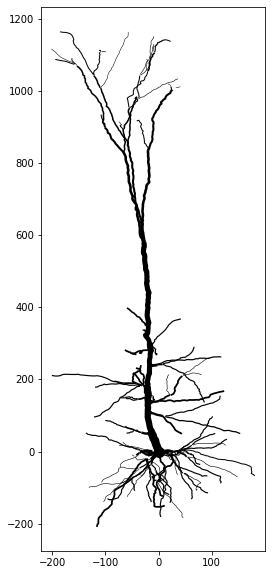

In [140]:
plt.figure(figsize=(4,10))
for i in exc_syns[exc_syns.Type=='apic']['Sec ID'].unique():
    plt.plot(exc_syns[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==i)]['Coord X'],
             exc_syns[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==i)]['Coord Y'],
             color='k',
             linewidth = 2*exc_syns[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==i)]['Section_diam'].unique())
    
for i in exc_syns[exc_syns.Type=='dend']['Sec ID'].unique():
    plt.plot(exc_syns[(exc_syns.Type=='dend')&(exc_syns['Sec ID']==i)]['Coord X'],
         exc_syns[(exc_syns.Type=='dend')&(exc_syns['Sec ID']==i)]['Coord Y'],
             color='k',
             linewidth = 2*exc_syns[(exc_syns.Type=='dend')&(exc_syns['Sec ID']==i)]['Section_diam'].unique())
    

plt.scatter(exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord X'],
         exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord Y'],color='k',s=100)
plt.savefig('morphology.svg')

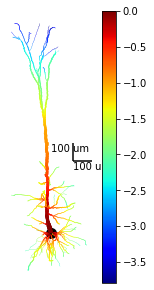

In [138]:
color_field = 'Elec_distance'

ax = plt.figure(figsize=(2,5))
import matplotlib
from matplotlib.colors import Normalize
cmap = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin = np.log10(exc_syns['Elec_distance'].min()), vmax = np.log10(exc_syns['Elec_distance'].max()))

for i in exc_syns[exc_syns.Type=='apic']['Sec ID'].unique():
    section = exc_syns[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==i)]
    for j in section.index.tolist()[:-1]:
        plt.plot(section.loc[j:j+1,'Coord X'],
                 section.loc[j:j+1,'Coord Y'],
             color=cmap(norm(np.log10(section.loc[j:j+1,color_field].values[0]))),
             linewidth = 1*section.loc[j:j+1,'Section_diam'].unique())
    
for i in exc_syns[exc_syns.Type=='dend']['Sec ID'].unique():
    section = exc_syns[(exc_syns.Type=='dend')&(exc_syns['Sec ID']==i)]
    for j in section.index.tolist()[:-1]:
        plt.plot(section.loc[j:j+1,'Coord X'],
                 section.loc[j:j+1,'Coord Y'],
             color=cmap(norm(np.log10(section.loc[j:j+1,color_field].values[0]))),
             linewidth = 1*section.loc[j:j+1,'Section_diam'].unique())
        
plt.scatter(exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord X'],
         exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord Y'],color='k',s=100)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap))
#cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('Elec_distance.svg')

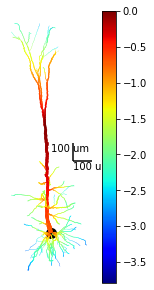

In [139]:
color_field = 'Elec_distance_nexus'

ax = plt.figure(figsize=(2,5))
import matplotlib
from matplotlib.colors import Normalize
cmap = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin = np.log10(exc_syns['Elec_distance'].min()), vmax = np.log10(exc_syns['Elec_distance'].max()))

for i in exc_syns[exc_syns.Type=='apic']['Sec ID'].unique():
    section = exc_syns[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==i)]
    for j in section.index.tolist()[:-1]:
        plt.plot(section.loc[j:j+1,'Coord X'],
                 section.loc[j:j+1,'Coord Y'],
             color=cmap(norm(np.log10(section.loc[j:j+1,color_field].values[0]))),
             linewidth = 1*section.loc[j:j+1,'Section_diam'].unique())
    
for i in exc_syns[exc_syns.Type=='dend']['Sec ID'].unique():
    section = exc_syns[(exc_syns.Type=='dend')&(exc_syns['Sec ID']==i)]
    for j in section.index.tolist()[:-1]:
        plt.plot(section.loc[j:j+1,'Coord X'],
                 section.loc[j:j+1,'Coord Y'],
             color=cmap(norm(np.log10(section.loc[j:j+1,color_field].values[0]))),
             linewidth = 1*section.loc[j:j+1,'Section_diam'].unique())
        
plt.scatter(exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord X'],
         exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord Y'],color='k',s=100)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap))
#cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('Elec_distance_nexus.svg')

In [115]:
exc_syns.head()

Type  Sec ID  segmentID  BMTK ID         X   Distance  Section_L  \
0  apic       0          1       85  0.055556  14.147771   46.13561   
1  apic       0          2       85  0.166667  19.273949   46.13561   
2  apic       0          3       85  0.277778  24.400128   46.13561   
3  apic       0          4       85  0.388889  29.526307   46.13561   
4  apic       0          5       85  0.500000  34.652486   46.13561   

   Section_diam   Coord X    Coord Y   Coord Z  Elec_distance  \
0      4.105518 -2.303151  11.476587  0.071639       0.999451   
1      4.105518 -3.554566  16.424751  0.046743       0.997676   
2      4.105518 -4.910495  21.177870 -1.216934       0.994614   
3      4.105518 -5.852709  26.024932 -2.438397       0.989382   
4      4.105518 -6.340006  30.845376 -2.985270       0.983055   

   Elec_distance_nexus  HVA_gbar  Degrees Elec_distanceQ  num_syns  
0             0.060147       0.0        1              9      10.0  
1             0.060366       0.0        1              9       5.0  
2             0.060742       0.0        1              9      17.0  
3             0.061380       0.0        1              9       4.0  
4             0.062150       0.0        1              9       3.0

In [160]:
exc_syns[(exc_syns['Coord Y']>500) & (exc_syns['Coord Y']<700)]['Sec ID'].unique()

array([36, 37, 50, 51, 60])

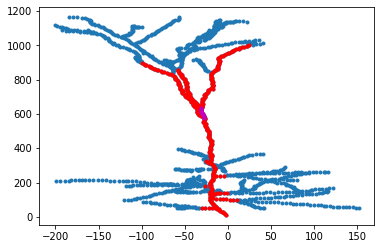

In [165]:
plt.plot(exc_syns[exc_syns.Type=='apic']['Coord X'],
         exc_syns[exc_syns.Type=='apic']['Coord Y'],'.')
plt.plot(exc_syns.loc[(exc_syns.Type=='apic')&(exc_syns['Section_diam']>1.0)]['Coord X'],
         exc_syns.loc[(exc_syns.Type=='apic')&(exc_syns['Section_diam']>1.0)]['Coord Y'],'r.')
plt.plot(exc_syns.loc[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==50)]['Coord X'],
         exc_syns.loc[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==50)]['Coord Y'],'m.')


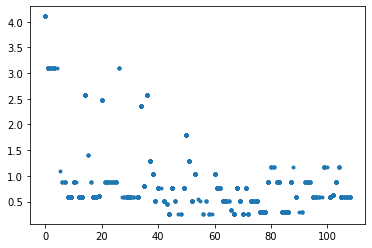

In [116]:
plt.plot(exc_syns[exc_syns.Type=='apic']['Sec ID'], exc_syns[exc_syns.Type=='apic']['Section_diam'], '.')

In [59]:
exc_syns.loc[(pd.isnull(exc_syns.num_syns))|(exc_syns.num_syns>30),'num_syns'] = 0
inh_syns.loc[pd.isnull(inh_syns.num_syns),'num_syns'] = 0

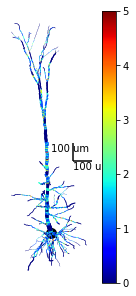

In [174]:
inh_syns_plot = inh_syns.copy()
inh_syns_plot.loc[inh_syns.num_syns==0,'num_syns'] = 1e-1

color_field = 'num_syns'

ax = plt.figure(figsize=(2,5))
import matplotlib
from matplotlib.colors import Normalize
cmap = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin = 0, vmax = 5)

for i in inh_syns_plot[inh_syns_plot.Type=='apic']['Sec ID'].unique():
    section = inh_syns_plot[(inh_syns_plot.Type=='apic')&(inh_syns_plot['Sec ID']==i)]
    for j in section.index.tolist()[:-1]:
        plt.plot(section.loc[j:j+1,'Coord X'],
                 section.loc[j:j+1,'Coord Y'],
             color=cmap(norm(section.loc[j:j+1,color_field].values[0])),
             linewidth = 1*section.loc[j:j+1,'Section_diam'].unique())
    
for i in inh_syns_plot[inh_syns_plot.Type=='dend']['Sec ID'].unique():
    section = inh_syns_plot[(inh_syns_plot.Type=='dend')&(inh_syns_plot['Sec ID']==i)]
    for j in section.index.tolist()[:-1]:
        plt.plot(section.loc[j:j+1,'Coord X'],
                 section.loc[j:j+1,'Coord Y'],
             color=cmap(norm(section.loc[j:j+1,color_field].values[0])),
             linewidth = 1*section.loc[j:j+1,'Section_diam'].unique())
        
plt.scatter(inh_syns_plot[(inh_syns_plot.Type=='soma')&(inh_syns_plot['Sec ID']==0)].loc[2523,'Coord X'],
         inh_syns_plot[(inh_syns_plot.Type=='soma')&(inh_syns_plot['Sec ID']==0)].loc[2523,'Coord Y'],color='k',s=100)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap))
#cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('inh_syns.svg')

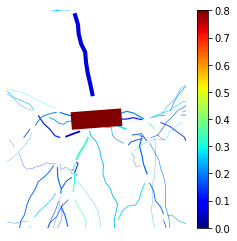

In [145]:
inh_syns_plot = inh_syns.copy()
inh_syns_plot.loc[inh_syns.num_syns==0,'num_syns'] = 1e-1

color_field = 'num_syns'

ax = plt.figure(figsize=(4,4))
import matplotlib
from matplotlib.colors import Normalize
cmap = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin = 0, vmax = 0.8)

for i in inh_syns_plot[inh_syns_plot.Type=='apic']['Sec ID'].unique():
    section_L = inh_syns_plot[(inh_syns_plot.Type=='apic')&(inh_syns_plot['Sec ID']==i)]['Section_L'].unique()[0]
    plt.plot(inh_syns_plot[(inh_syns_plot.Type=='apic')&(inh_syns_plot['Sec ID']==i)]['Coord X'],
             inh_syns_plot[(inh_syns_plot.Type=='apic')&(inh_syns_plot['Sec ID']==i)]['Coord Y'],
             color=cmap(norm(inh_syns_plot[(inh_syns_plot.Type=='apic')&(inh_syns_plot['Sec ID']==i)][color_field].sum()/section_L)),
             linewidth = 1*inh_syns_plot[(inh_syns_plot.Type=='apic')&(inh_syns_plot['Sec ID']==i)]['Section_diam'].unique())
    
for i in inh_syns_plot[inh_syns_plot.Type=='dend']['Sec ID'].unique():
    section_L = inh_syns_plot[(inh_syns_plot.Type=='dend')&(inh_syns_plot['Sec ID']==i)]['Section_L'].unique()[0]
    plt.plot(inh_syns_plot[(inh_syns_plot.Type=='dend')&(inh_syns_plot['Sec ID']==i)]['Coord X'],
             inh_syns_plot[(inh_syns_plot.Type=='dend')&(inh_syns_plot['Sec ID']==i)]['Coord Y'],
             color=cmap(norm(inh_syns_plot[(inh_syns_plot.Type=='dend')&(inh_syns_plot['Sec ID']==i)][color_field].sum()/section_L)),
             linewidth = 1*inh_syns_plot[(inh_syns_plot.Type=='dend')&(inh_syns_plot['Sec ID']==i)]['Section_diam'].unique())
    
for i in inh_syns_plot[inh_syns_plot.Type=='soma']['Sec ID'].unique():
    section_L = inh_syns_plot[(inh_syns_plot.Type=='soma')&(inh_syns_plot['Sec ID']==i)]['Section_L'].unique()[0]
    plt.plot(inh_syns_plot[(inh_syns_plot.Type=='soma')&(inh_syns_plot['Sec ID']==i)]['Coord X'],
             inh_syns_plot[(inh_syns_plot.Type=='soma')&(inh_syns_plot['Sec ID']==i)]['Coord Y'],
             color=cmap(norm(inh_syns_plot[(inh_syns_plot.Type=='soma')&(inh_syns_plot['Sec ID']==i)][color_field].sum()/section_L)),
             linewidth = 1*inh_syns_plot[(inh_syns_plot.Type=='soma')&(inh_syns_plot['Sec ID']==i)]['Section_diam'].unique())
#    
#
#plt.scatter(exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord X'],
#         exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord Y'],color='k',s=100)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap))
#cbar = plt.colorbar()
#cbar.ax.set_ylabel('log(num. inh. synapses)', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.ylim(-50,50)
plt.xlim(-50,50)
plt.savefig('inh_syns_zoom.svg')

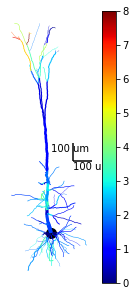

In [151]:
color_field = 'num_syns'
minval = np.log10(exc_syns[color_field].min())

ax = plt.figure(figsize=(2,5))
import matplotlib
from matplotlib.colors import Normalize
cmap = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin = 0, vmax = 8)

for i in exc_syns[exc_syns.Type=='apic']['Sec ID'].unique():
    section_L = exc_syns[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==i)]['Section_L'].unique()[0]
    plt.plot(exc_syns[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==i)]['Coord X'],
             exc_syns[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==i)]['Coord Y'],
             color=cmap(norm(exc_syns[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==i)][color_field].sum()/section_L)),
             linewidth = 1*exc_syns[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==i)]['Section_diam'].unique())
    
for i in exc_syns[exc_syns.Type=='dend']['Sec ID'].unique():
    section_L = exc_syns[(exc_syns.Type=='dend')&(exc_syns['Sec ID']==i)]['Section_L'].unique()[0]
    plt.plot(exc_syns[(exc_syns.Type=='dend')&(exc_syns['Sec ID']==i)]['Coord X'],
             exc_syns[(exc_syns.Type=='dend')&(exc_syns['Sec ID']==i)]['Coord Y'],
             color=cmap(norm(exc_syns[(exc_syns.Type=='dend')&(exc_syns['Sec ID']==i)][color_field].sum()/section_L)),
             linewidth = 1*exc_syns[(exc_syns.Type=='dend')&(exc_syns['Sec ID']==i)]['Section_diam'].unique())
#    
#
plt.scatter(exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord X'],
         exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord Y'],color='k',s=100)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap))
#cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('exc_syns.svg')

In [152]:
segs = pd.read_csv('/Volumes/TOSHIBA EXT/L5NeuronSimulation_new/L5NeuronSimulation/MorphAnalysis/Segments.csv')

In [153]:
segs['median_v'] = 0

In [154]:
for s in segs.index:
    print(s)
    segs.loc[s,'median_v'] = np.median(v['report']['biophysical']['data'][1000:10000,s])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064


In [155]:
segs.head()

BMTK ID    X  Type  Sec ID   Distance  Section_L  Section_diam   Coord X  \
0        0  0.1  soma       0   2.316936  23.169362     17.526643 -9.249733   
1        0  0.3  soma       0   6.950809  23.169362     17.526643 -4.624868   
2        0  0.5  soma       0  11.584681  23.169362     17.526643 -0.000010   
3        0  0.7  soma       0  16.218553  23.169362     17.526643  4.624854   
4        0  0.9  soma       0  20.852426  23.169362     17.526643  9.249712   

    Coord Y  Coord Z  Elec_distance  HVA_gbar   median_v  
0 -0.577674      0.0       0.998363  0.000992 -65.734214  
1 -0.288877      0.0       0.999389  0.000992 -65.725079  
2  0.000021      0.0       1.000000  0.000992 -65.714281  
3  0.288824      0.0       0.999401  0.000992 -65.724602  
4  0.577722      0.0       0.998340  0.000992 -65.731326

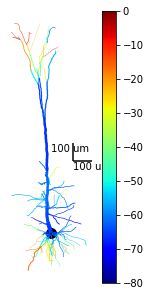

In [159]:
color_field = 'median_v'

ax = plt.figure(figsize=(2,5))
import matplotlib
from matplotlib.colors import Normalize
cmap = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin = -80, vmax = 0)

for i in segs[segs.Type=='apic']['Sec ID'].unique():
    section_L = segs[(segs.Type=='apic')&(segs['Sec ID']==i)]['Section_L'].unique()[0]
    plt.plot(segs[(segs.Type=='apic')&(segs['Sec ID']==i)]['Coord X'],
             segs[(segs.Type=='apic')&(segs['Sec ID']==i)]['Coord Y'],
             color=cmap(norm(segs[(segs.Type=='apic')&(segs['Sec ID']==i)][color_field].mean())),
             linewidth = 1*segs[(segs.Type=='apic')&(segs['Sec ID']==i)]['Section_diam'].unique())
    
for i in segs[segs.Type=='dend']['Sec ID'].unique():
    section_L = segs[(segs.Type=='dend')&(segs['Sec ID']==i)]['Section_L'].unique()[0]
    plt.plot(segs[(segs.Type=='dend')&(segs['Sec ID']==i)]['Coord X'],
             segs[(segs.Type=='dend')&(segs['Sec ID']==i)]['Coord Y'],
             color=cmap(norm(segs[(segs.Type=='dend')&(segs['Sec ID']==i)][color_field].mean())),
             linewidth = 1*segs[(segs.Type=='dend')&(segs['Sec ID']==i)]['Section_diam'].unique())
#    
#
plt.scatter(exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord X'],
         exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord Y'],color='k',s=100)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap))
#cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('median_v.svg')

## Plotting morphology and voltage traces

In [8]:
plt.figure(figsize=(3,10))
for i in exc_syns[exc_syns.Type=='apic']['Sec ID'].unique():
    plt.plot(exc_syns[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==i)]['Coord X'],
             exc_syns[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==i)]['Coord Y'],
             color='k',
             linewidth = 2*exc_syns[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==i)]['Section_diam'].unique())
    
for i in exc_syns[exc_syns.Type=='dend']['Sec ID'].unique():
    plt.plot(exc_syns[(exc_syns.Type=='dend')&(exc_syns['Sec ID']==i)]['Coord X'],
         exc_syns[(exc_syns.Type=='dend')&(exc_syns['Sec ID']==i)]['Coord Y'],
             color='k',
             linewidth = 2*exc_syns[(exc_syns.Type=='dend')&(exc_syns['Sec ID']==i)]['Section_diam'].unique())
    

plt.scatter(exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord X'],
         exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord Y'],color='k',s=100)

plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.plot(segs.loc[segs.segmentID==1959,'Coord X'], 
         segs.loc[segs.segmentID==1959,'Coord Y'],
         'r*')
plt.plot(segs.loc[segs.segmentID==1112,'Coord X'], 
         segs.loc[segs.segmentID==1112,'Coord Y'],
         'b*')
plt.plot(segs.loc[segs.segmentID==1046,'Coord X'], 
         segs.loc[segs.segmentID==1046,'Coord Y'],
         'm*')
plt.plot(segs.loc[segs.segmentID==1500,'Coord X'], 
         segs.loc[segs.segmentID==1500,'Coord Y'],
         'g*')
plt.plot(segs.loc[segs.segmentID==680,'Coord X'], 
         segs.loc[segs.segmentID==680,'Coord Y'],
         '*',color='orange')
plt.plot(segs.loc[segs.segmentID==482,'Coord X'], 
         segs.loc[segs.segmentID==482,'Coord Y'],
         '*',color='grey')
plt.savefig('fig1A.svg')

NameError: name 'exc_syns' is not defined

<Figure size 216x720 with 0 Axes>

In [98]:
na_df = pd.read_csv('na_df.csv')
nmda_df = pd.read_csv('nmda_df.csv')
ca_df = pd.read_csv('ca_df.csv')

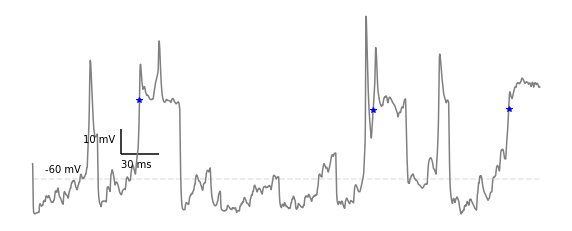

In [203]:
t = 482

plt.figure(figsize=(10,4))
s1 = 1147000#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,t],color='grey')
na_spks = na_df[(na_df.segmentID==t)&(na_df.na_lower_bound>s1) & (na_df.na_lower_bound<s1+4000)]
plt.plot(np.arange(0,400,.1)[na_spks['na_lower_bound'].astype(int).values-s1],
         v['report']['biophysical']['data'][na_spks['na_lower_bound'].astype(int).values,t],'r*')
nmda_spks = nmda_df[(nmda_df.segmentID==t)&(nmda_df.nmda_lower_bound>s1) & (nmda_df.nmda_lower_bound<s1+4000)]
plt.plot(np.arange(0,400,.1)[nmda_spks['nmda_lower_bound'].astype(int).values-s1],
         v['report']['biophysical']['data'][nmda_spks['nmda_lower_bound'].astype(int).values,t],'b*')
plt.hlines(-60,0,400,color='grey',linestyle='dashed',alpha=0.2)
plt.text(10,-57,'-60 mV')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2G.svg')

In [204]:
segs[segs.Type=='soma']

Type  Sec ID  BMTK ID    X   Distance  Section_L  Section_diam  \
2521  soma       0        0  0.1   2.316936  23.169362     17.526643   
2522  soma       0        0  0.3   6.950809  23.169362     17.526643   
2523  soma       0        0  0.5  11.584681  23.169362     17.526643   
2524  soma       0        0  0.7  16.218553  23.169362     17.526643   
2525  soma       0        0  0.9  20.852426  23.169362     17.526643   

       Coord X   Coord Y  Coord Z  Elec_distance  HVA_gbar  segmentID  \
2521 -9.249733 -0.577674      0.0       0.998363  0.000992          0   
2522 -4.624868 -0.288877      0.0       0.999389  0.000992          1   
2523 -0.000010  0.000021      0.0       1.000000  0.000992          2   
2524  4.624854  0.288824      0.0       0.999401  0.000992          3   
2525  9.249712  0.577722      0.0       0.998340  0.000992          4   

      Degrees Elec_distanceQ  
2521        0           None  
2522        0           None  
2523        0           None  
2524        0           None  
2525        0           None

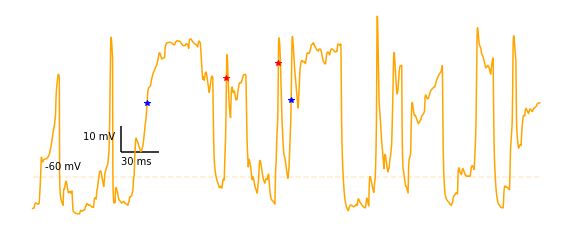

In [202]:
plt.figure(figsize=(10,4))
s1 = 1147000#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
t = 88

plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,t],color='orange')
na_spks = na_df[(na_df.segmentID==t)&(na_df.na_lower_bound>s1) & (na_df.na_lower_bound<s1+4000)]
plt.plot(np.arange(0,400,.1)[na_spks['na_lower_bound'].astype(int).values-s1],
         v['report']['biophysical']['data'][na_spks['na_lower_bound'].astype(int).values,t],'r*')
nmda_spks = nmda_df[(nmda_df.segmentID==t)&(nmda_df.nmda_lower_bound>s1) & (nmda_df.nmda_lower_bound<s1+4000)]
plt.plot(np.arange(0,400,.1)[nmda_spks['nmda_lower_bound'].astype(int).values-s1],
         v['report']['biophysical']['data'][nmda_spks['nmda_lower_bound'].astype(int).values,t],'b*')
plt.hlines(-60,0,400,color='orange',linestyle='dashed',alpha=0.2)
plt.text(10,-57,'-60 mV')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])

plt.savefig('fig2F.svg')

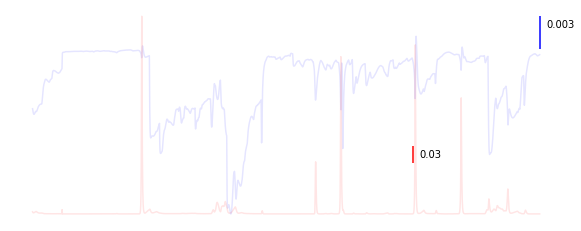

In [91]:
plt.figure(figsize=(10,4))
plt.plot(np.arange(0,400,.1),nmda['report']['biophysical']['data'][s1:s1+4000,t],color='b',alpha=0.1)
plt.vlines(400,0,0.003,color='b')
plt.text(405,0.002,'0.003')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.twinx()
plt.plot(np.arange(0,400,.1),100*na['report']['biophysical']['data'][s1:s1+4000,t],color='r',alpha=0.1)
plt.vlines(300,0.09,0.12,color='r')
plt.text(305,0.1,'0.03')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2F_na_nmda.svg')

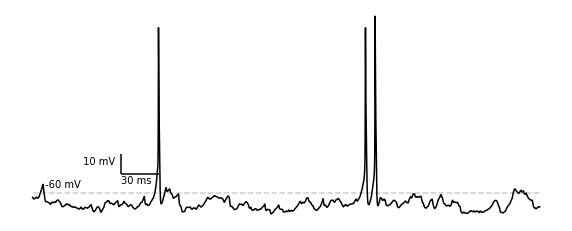

In [198]:
plt.figure(figsize=(10,4))
s1 = 1147000#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,0],color='k')
plt.hlines(-60,0,400,color='k',linestyle='dashed',alpha=0.2)
plt.text(10,-57,'-60 mV')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2E.svg')

In [126]:
ca_df[ca_df.segmentID==1500]['ca_lower_bound'].values

array([     36,   10566,   16347,   50506,   83839,  102296,  123244,
        131535,  140663,  162813,  164838,  169120,  175262,  177370,
        182826,  188296,  196185,  216036,  225826,  248304,  251838,
        262300,  282002,  311105,  332572,  365301,  379146,  454064,
        455271,  465382,  478305,  494777,  535099,  539431,  550098,
        593193,  608711,  609326,  623698,  632070,  637481,  656120,
        661707,  683464,  689290,  715548,  719465,  727620,  737137,
        751296,  779651,  789407,  803351,  815222,  829779,  843246,
        868386,  876572,  882938,  898599,  899308,  916285,  918884,
        921757,  942591,  952668,  960578,  983846,  988659,  998310,
       1008420, 1014803, 1021067, 1022192, 1056520, 1060326, 1066954,
       1090058, 1115975, 1149158, 1175254, 1192351, 1212143, 1212599,
       1215733, 1223982, 1234728, 1286789, 1302160, 1303370, 1307890,
       1370547, 1382458, 1383402, 1389062, 1460091, 1466486, 1471944])

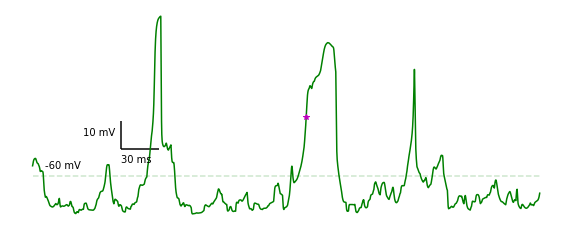

In [197]:
plt.figure(figsize=(10,4))
s1 = 1147000#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
t = 1500
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,t],color='g')
na_spks = na_df[(na_df.segmentID==t)&(na_df.na_lower_bound>s1) & (na_df.na_lower_bound<s1+4000)]
plt.plot(np.arange(0,400,.1)[na_spks['na_lower_bound'].astype(int).values-s1],
         v['report']['biophysical']['data'][na_spks['na_lower_bound'].astype(int).values,t],'r*')
nmda_spks = nmda_df[(nmda_df.segmentID==t)&(nmda_df.nmda_lower_bound>s1) & (nmda_df.nmda_lower_bound<s1+4000)]
plt.plot(np.arange(0,400,.1)[nmda_spks['nmda_lower_bound'].astype(int).values-s1],
         v['report']['biophysical']['data'][nmda_spks['nmda_lower_bound'].astype(int).values,t],'b*')
ca_spks = ca_df[(ca_df.segmentID==t)&(ca_df.ca_lower_bound>s1) & (ca_df.ca_lower_bound<s1+4000)]
plt.plot(np.arange(0,400,.1)[ca_spks['ca_lower_bound'].astype(int).values-s1],
         v['report']['biophysical']['data'][ca_spks['ca_lower_bound'].astype(int).values,t],'m*')
plt.hlines(-60,0,400,color='g',linestyle='dashed',alpha=0.2)
plt.text(10,-57,'-60 mV')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2C.svg')

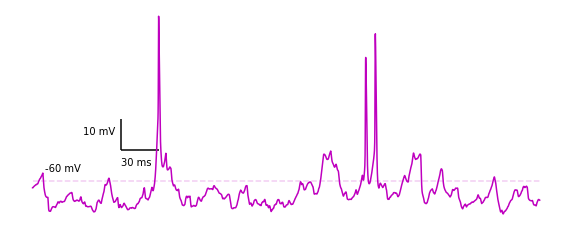

In [199]:
plt.figure(figsize=(10,4))
s1 = 1147000#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
t = 1046
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,t],color='m')
na_spks = na_df[(na_df.segmentID==t)&(na_df.na_lower_bound>s1) & (na_df.na_lower_bound<s1+4000)]
plt.plot(np.arange(0,400,.1)[na_spks['na_lower_bound'].astype(int).values-s1],
         v['report']['biophysical']['data'][na_spks['na_lower_bound'].astype(int).values,t],'r*')
nmda_spks = nmda_df[(nmda_df.segmentID==t)&(nmda_df.nmda_lower_bound>s1) & (nmda_df.nmda_lower_bound<s1+4000)]
plt.plot(np.arange(0,400,.1)[nmda_spks['nmda_lower_bound'].astype(int).values-s1],
         v['report']['biophysical']['data'][nmda_spks['nmda_lower_bound'].astype(int).values,t],'b*')
plt.hlines(-60,0,400,color='m',linestyle='dashed',alpha=0.2)
plt.text(10,-57,'-60 mV')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2D.svg')

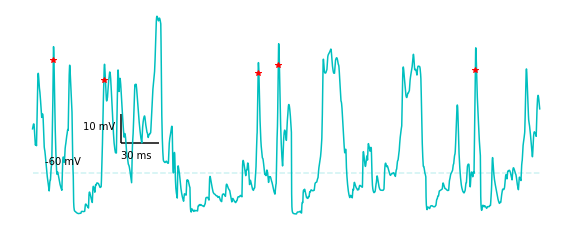

In [200]:
plt.figure(figsize=(10,4))
s1 = 1147000#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
t = 1249
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,t],color='c')
na_spks = na_df[(na_df.segmentID==t)&(na_df.na_lower_bound>s1) & (na_df.na_lower_bound<s1+4000)]
plt.plot(np.arange(0,400,.1)[na_spks['na_lower_bound'].astype(int).values-s1],
         v['report']['biophysical']['data'][na_spks['na_lower_bound'].astype(int).values,t],'r*')
nmda_spks = nmda_df[(nmda_df.segmentID==t)&(nmda_df.nmda_lower_bound>s1) & (nmda_df.nmda_lower_bound<s1+4000)]
plt.plot(np.arange(0,400,.1)[nmda_spks['nmda_lower_bound'].astype(int).values-s1],
         v['report']['biophysical']['data'][nmda_spks['nmda_lower_bound'].astype(int).values,t],'b*')
plt.hlines(-60,0,400,color='c',linestyle='dashed',alpha=0.2)
plt.text(10,-57,'-60 mV')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2B.svg')

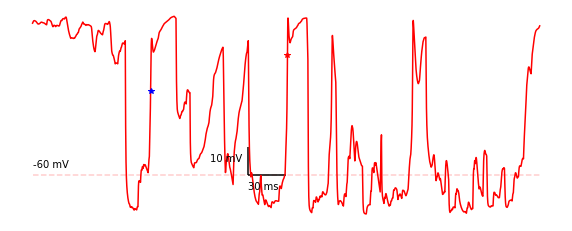

In [201]:
plt.figure(figsize=(10,4))
s1 = 1147000#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
t = 1800
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,t],color='r')
na_spks = na_df[(na_df.segmentID==t)&(na_df.na_lower_bound>s1) & (na_df.na_lower_bound<s1+4000)]
plt.plot(np.arange(0,400,.1)[na_spks['na_lower_bound'].astype(int).values-s1],
         v['report']['biophysical']['data'][na_spks['na_lower_bound'].astype(int).values,t],'r*')
nmda_spks = nmda_df[(nmda_df.segmentID==t)&(nmda_df.nmda_lower_bound>s1) & (nmda_df.nmda_lower_bound<s1+4000)]
plt.plot(np.arange(0,400,.1)[nmda_spks['nmda_lower_bound'].astype(int).values-s1],
         v['report']['biophysical']['data'][nmda_spks['nmda_lower_bound'].astype(int).values,t],'b*')
plt.hlines(-60,0,400,color='r',linestyle='dashed',alpha=0.2)
plt.text(0,-57,'-60 mV')
#1433413, 1161455
plt.hlines(-60,170,200)
plt.text(170,-65,'30 ms')
plt.vlines(170,-60,-50)
plt.text(140,-55,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2A.svg')

([], <a list of 0 Text yticklabel objects>)

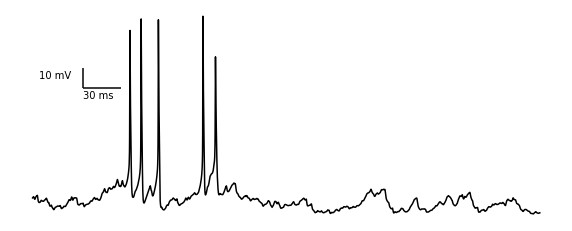

In [176]:
plt.figure(figsize=(10,4))
s1 = 559133+1000#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,0],color='k')
#1433413, 1161455
plt.hlines(-10,40,70)
plt.text(40,-15,'30 ms')
plt.vlines(40,-10,0)
plt.text(5,-5,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])

In [195]:
x = ca_df[~pd.isnull(ca_df.ca_lower_bound)].reset_index()
i = np.random.choice(x.index)

(0, 200)

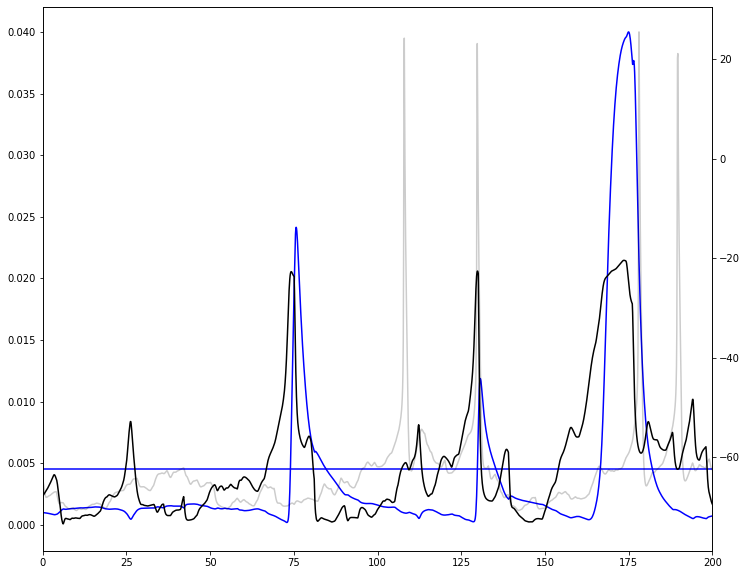

In [35]:
seg = 1842
lower_bound = 15000
plt.figure(figsize=(12,10))
plt.plot(np.arange(0,600,.1),-(hva['report']['biophysical']['data'][lower_bound-1000:lower_bound+5000,seg]+\
         lva['report']['biophysical']['data'][lower_bound-1000:lower_bound+5000,seg]+\
         ih['report']['biophysical']['data'][lower_bound-1000:lower_bound+5000,seg]),color='b')
plt.hlines(np.mean(-(hva['report']['biophysical']['data'][lower_bound-1000:lower_bound+5000,seg]+\
         lva['report']['biophysical']['data'][lower_bound-1000:lower_bound+5000,seg]+\
         ih['report']['biophysical']['data'][lower_bound-1000:lower_bound+5000,seg])),0,600,color='b')
plt.xlim(0,200)

plt.twinx()
plt.plot(np.arange(0,600,.1),v['report']['biophysical']['data'][lower_bound-1000:lower_bound+5000,seg],color='k')
plt.plot(np.arange(0,600,.1),v['report']['biophysical']['data'][lower_bound-1000:lower_bound+5000,0],color='k',alpha=0.2)
plt.xlim(0,200)


In [189]:
ca_df.reset_index(inplace=True)

In [201]:
for i in np.random.choice(ca_df[(ca_df.ca_lower_bound>2000) & (ca_df.ca_lower_bound<1400000)].index,100):
    seg = ca_df.loc[i,'segmentID']
    if not pd.isnull(ca_df.loc[i,'ca_lower_bound']):
        spkt = int(ca_df.loc[i,'ca_lower_bound'])
        
        trace = -(hva['report']['biophysical']['data'][spkt-1000:spkt+1000,seg] + \
                lva['report']['biophysical']['data'][spkt-1000:spkt+1000,seg] + \
                ih['report']['biophysical']['data'][spkt-1000:spkt+1000,seg])
        peak_value = np.max(trace)
        half_peak = peak_value/2
        duration = np.arange(0,2000)[trace>half_peak] + spkt - 10
        ca_df.loc[i,'duration_low'] = duration[0]
        ca_df.loc[i,'duration_high'] = duration[-1]
        ca_df.loc[i,'peak_value'] = peak_value
    else:
        ca_df.loc[i,'duration_low'] = np.nan
        ca_df.loc[i,'duration_high'] = np.nan
        ca_df.loc[i,'peak_value'] = np.nan

In [203]:
ca_df[~pd.isnull(ca_df.duration_high)]

index segmentID ca_lower_bound  duration_low  duration_high  \
2563      158      1069         507212      508191.0       508356.0   
4296      362      1072        1254601     1254678.0      1255713.0   
7196      105      1113         349293      350266.0       351131.0   
7241      150      1113         495356      495775.0       496369.0   
8421      400      1115        1259735     1260697.0      1261017.0   
...       ...       ...            ...           ...            ...   
311425     78      2403         204744      205494.0       205794.0   
312627    192      2405         457039      457064.0       458052.0   
314071    372      2407         810363      810543.0       812048.0   
315127     21      2409          55870       56852.0        57859.0   
327976     16      2461         362410      363410.0       363522.0   

        peak_value  
2563      0.003170  
4296      0.002945  
7196      0.002592  
7241      0.003116  
8421      0.002950  
...            ...  
311425    0.003171  
312627    0.002928  
314071    0.003003  
315127    0.003151  
327976    0.003142  

[137 rows x 6 columns]

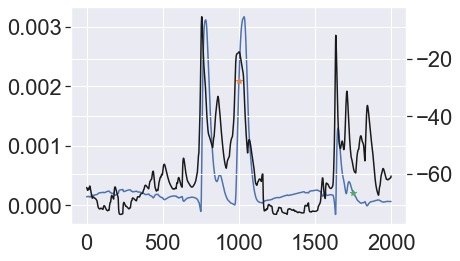

In [210]:
seg = 2403
lower_bound = 204744
#upper_bound = 
plt.plot(-(hva['report']['biophysical']['data'][lower_bound-1000:lower_bound+1000,seg]+\
         lva['report']['biophysical']['data'][lower_bound-1000:lower_bound+1000,seg]+\
         ih['report']['biophysical']['data'][lower_bound-1000:lower_bound+1000,seg]))
plt.plot(1000,-(hva['report']['biophysical']['data'][lower_bound,seg]+\
         lva['report']['biophysical']['data'][lower_bound,seg]+\
         ih['report']['biophysical']['data'][lower_bound,seg]),'*')

plt.plot(1000+205494-lower_bound,-(hva['report']['biophysical']['data'][205494,seg]+\
         lva['report']['biophysical']['data'][205494,seg]+\
         ih['report']['biophysical']['data'][205494,seg]),'*')

plt.twinx()
plt.plot(v['report']['biophysical']['data'][lower_bound-1000:lower_bound+1000,seg],color='k')

----------

In [9]:
ca_df = pd.read_csv('ca_df.csv')

In [10]:
segs_ca_df = segs.set_index('segmentID').join(ca_df.set_index('segmentID')).reset_index() 

In [15]:
def get_ca_sta(segs_ca_df, spktimes):

    ca_apic = np.zeros((10,27,))
    #(~pd.isnull(segs_ca_df.ca_lower_bound))&
    edges_apic=np.quantile(segs_ca_df[(segs_ca_df.Type=='apic')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    
    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                ca_inds = segs_ca_df[(~pd.isnull(segs_ca_df.ca_lower_bound))&
                                     (segs_ca_df.Type=='apic')&
                                     (segs_ca_df.Elec_distance>edges_apic[e])&
                                     (segs_ca_df.Elec_distance<=edges_apic[e+1])]['ca_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(ca_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                ca_apic[e] += x2
                
                
            
            actual_spktimes.append(i)
        c = i
    return ca_apic

In [16]:
ca_apic = get_ca_sta(segs_ca_df, spktimes)

In [17]:
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spktimes.shape[0]))
ca_apic_rand = get_ca_sta(segs_ca_df, rand_spktimes)

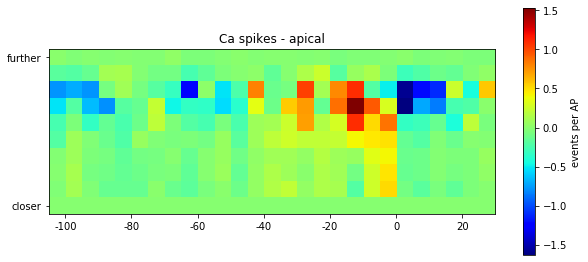

In [18]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Ca spikes - apical')
plt.imshow((ca_apic-ca_apic_rand)/len(spktimes),cmap='jet')
plt.xticks(ticks=np.arange(0,26,4)+0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
#plt.xticks(ticks=np.arange(0,40,2)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,2)])
plt.colorbar(label='events per AP')
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.savefig('caspikes.svg')
plt.show()

# NMDA effect on calcium

In [13]:
ca_spktimes = segs_ca_df[(segs_ca_df.Type=='apic') & (segs_ca_df['Sec ID']==50)]['ca_lower_bound']/10
#ca_spktimes = segs_ca_df[segs_ca_df.segmentID==1738]['ca_lower_bound']/10

In [14]:
def get_nmda_sta_calcium(segs_nmda_df, spktimes):    
    nmda_dend = np.zeros((10,27,))
    nmda_apic = np.zeros((10,27,))
    
    edges_dend=np.quantile(segs_nmda_df[(segs_nmda_df.Type=='dend')]['Elec_distance_nexus'].unique(),np.arange(0,1.1,0.1))
    edges_apic=np.quantile(segs_nmda_df[(segs_nmda_df.Type=='apic')]['Elec_distance_nexus'].unique(),np.arange(0,1.1,0.1))
    
    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                     (segs_nmda_df.Type=='dend')&
                                     (segs_nmda_df.Elec_distance_nexus>edges_dend[e])&
                                     (segs_nmda_df.Elec_distance_nexus<=edges_dend[e+1])]['nmda_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                nmda_dend[e] += x2
                
                nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                     (segs_nmda_df.Type=='apic')&
                                     (segs_nmda_df.Elec_distance_nexus>edges_apic[e])&
                                     (segs_nmda_df.Elec_distance_nexus<=edges_apic[e+1])]['nmda_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                nmda_apic[e] += x2
            
            actual_spktimes.append(i)
        c = i
        
    return nmda_dend, nmda_apic

In [15]:
edges_apic=np.quantile(segs_nmda_df[(segs_nmda_df.Type=='apic')]['Elec_distance_nexus'].unique(),np.arange(0,1.1,0.1))

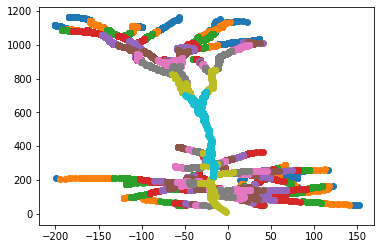

In [16]:
for i in np.arange(0,len(edges_apic)-1):
    plt.scatter(segs_nmda_df[(segs_nmda_df.Type=='apic')&
                         (segs_nmda_df.Elec_distance_nexus>=edges_apic[i])&
                         (segs_nmda_df.Elec_distance_nexus<edges_apic[i+1])]['Coord X'],
                segs_nmda_df[(segs_nmda_df.Type=='apic')&
                         (segs_nmda_df.Elec_distance_nexus>=edges_apic[i])&
                         (segs_nmda_df.Elec_distance_nexus<edges_apic[i+1])]['Coord Y'])

In [17]:
ca_spktimes_nodupes = np.sort(ca_spktimes[1:])[np.diff(np.sort(ca_spktimes))>100]

In [18]:
nmda_dend, nmda_apic = get_nmda_sta_calcium(segs_nmda_df,ca_spktimes_nodupes)
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), ca_spktimes_nodupes.shape[0]))
nmda_dend_rand, nmda_apic_rand = get_nmda_sta_calcium(segs_nmda_df, rand_spktimes)

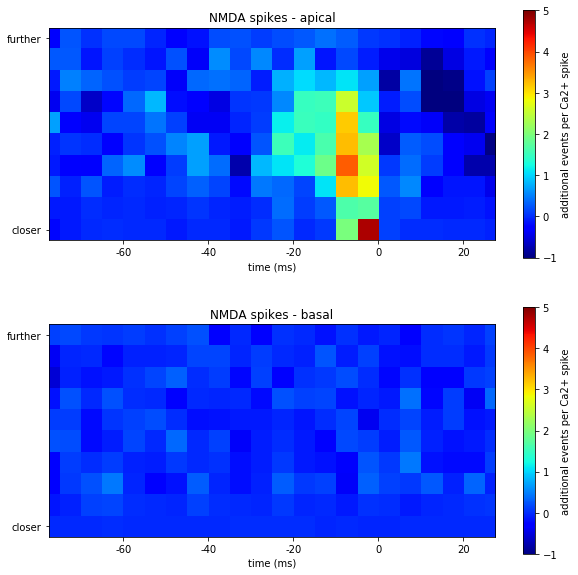

In [23]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('NMDA spikes - apical')
x = (nmda_apic-nmda_apic_rand)/ca_spktimes_nodupes.shape[0]
plt.imshow(x,cmap='jet',vmin = -1, vmax = 5)
plt.xticks(ticks=np.arange(0,26,4)+0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per Ca2+ spike')
plt.xlabel('time (ms)')
plt.xlim(5,26)

plt.subplot(2,1,2)
plt.title('NMDA spikes - basal')
x = (nmda_dend-nmda_dend_rand)/ca_spktimes_nodupes.shape[0]
plt.imshow(x,cmap='jet',vmin = -1, vmax = 5)
plt.xticks(ticks=np.arange(0,26,4)+0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per Ca2+ spike')
plt.xlim(5,26)

plt.xlabel('time (ms)')
plt.savefig('nmdaspikes.svg')
plt.show()

# Na effect on Calcium

In [24]:
def get_sta_calcium(segs_na_df, spktimes):
    na_dend = np.zeros((10,39,))
    na_apic = np.zeros((10,39,))
    
    edges_dend=np.quantile(segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                       (segs_na_df.Type=='dend')]['Elec_distance_nexus'].unique(),np.arange(0,1.1,0.1))
    
    edges_apic=np.quantile(segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                       (segs_na_df.Type=='apic')]['Elec_distance_nexus'].unique(),np.arange(0,1.1,0.1))
    
    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                na_inds = segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                     (segs_na_df.Type=='dend')&
                                     (segs_na_df.Elec_distance_nexus>edges_dend[e])&
                                     (segs_na_df.Elec_distance_nexus<=edges_dend[e+1])]['na_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(na_inds/10,bins=np.arange(np.floor(i)-20,np.floor(i)+20,1))
                na_dend[e] += x2
                
                na_inds = segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                     (segs_na_df.Type=='apic')&
                                     (segs_na_df.Elec_distance_nexus>edges_apic[e])&
                                     (segs_na_df.Elec_distance_nexus<=edges_apic[e+1])]['na_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(na_inds/10,bins=np.arange(np.floor(i)-20,np.floor(i)+20,1))
                na_apic[e] += x2
            
            actual_spktimes.append(i)
        c = i
    return na_dend, na_apic

In [25]:
na_dend, na_apic = get_sta_calcium(segs_na_df, ca_spktimes_nodupes)
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), ca_spktimes_nodupes.shape[0]))
na_dend_rand, na_apic_rand = get_sta_calcium(segs_na_df, rand_spktimes)

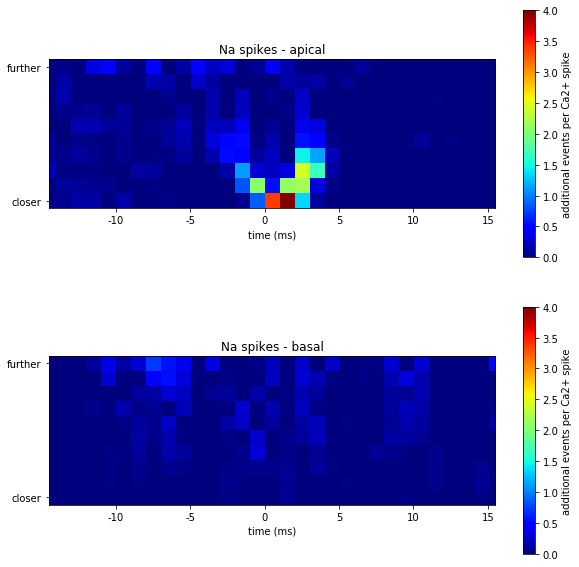

In [29]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Na spikes - apical')
x = (na_apic-na_apic_rand)/ca_spktimes_nodupes.shape[0]
plt.imshow(x,cmap='jet',vmin=0,vmax=4)
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per Ca2+ spike')
plt.xlabel('time (ms)')
plt.xlim(5,35)

plt.subplot(2,1,2)
plt.title('Na spikes - basal')
x = (na_dend-na_dend_rand)/ca_spktimes_nodupes.shape[0]
plt.imshow(x,cmap='jet',vmin=0,vmax=4)
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per Ca2+ spike')
plt.xlim(5,35)

plt.xlabel('time (ms)')
plt.savefig('naspikes.svg')
plt.show()

In [124]:
nmda_apic = np.zeros((10,27,))
mean_nmda = np.zeros((1,1400))
nmda_traces = []

nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                             (segs_nmda_df.Type=='apic')]['nmda_lower_bound'].values.astype(int)

for i in np.random.choice(ca_spktimes[ca_spktimes>100], 100):
    x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
    nmda_apic[0,:] += x2
    # mean of i_nmda across all apical segments that had an nmda spike in this window
    segs_of_interest = segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                    (segs_nmda_df['Coord Y']>800)&
                                    (segs_nmda_df['Coord Y']<900)&
                                    (segs_nmda_df.Type=='apic')&
                                    (segs_nmda_df.nmda_lower_bound>int(np.floor(i)-100)*10)&
                                    (segs_nmda_df.nmda_lower_bound<int(np.floor(i)+40)*10)]['segmentID'].values
    nmda_traces.append(nmda['report']['biophysical']['data'][int(np.floor(i)-100)*10:int(np.floor(i)+40)*10,
                                                                    np.unique(np.sort(segs_of_interest))])

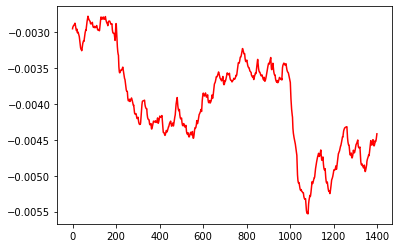

In [128]:
T = []
for i in np.arange(0,len(nmda_traces)):
    #plt.plot(nmda_traces[i][:,0],color='k',alpha=0.2)
    T.append(nmda_traces[i][:,0])
plt.plot(np.mean(np.array(T),axis=0),color='r')

In [20]:
nmda_dend, nmda_apic = get_nmda_sta(segs_nmda_df, ca_spktimes)
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), ca_spktimes.shape[0]))
nmda_dend_rand, nmda_apic_rand = get_nmda_sta(segs_nmda_df, rand_spktimes)

KeyboardInterrupt: 

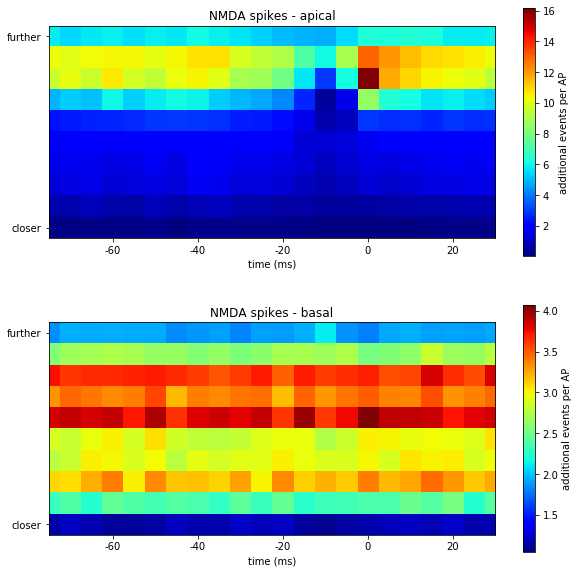

In [45]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('NMDA spikes - apical')
plt.imshow((nmda_apic-nmda_apic_rand)/len(spktimes),cmap='jet')
plt.xticks(ticks=np.arange(0,26,4),labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlabel('time (ms)')
plt.xlim(5,26)

plt.subplot(2,1,2)
plt.title('NMDA spikes - basal')
plt.imshow((nmda_dend-nmda_dend_rand)/len(spktimes),cmap='jet')
plt.xticks(ticks=np.arange(0,26,4),labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlim(5,26)

plt.xlabel('time (ms)')
plt.savefig('nmdaspikes.svg')
plt.show()

----------------------

In [20]:
apic_exc = segs_conns[(segs_conns['Source Population']=='exc_stim')&(segs_conns.Type=='apic')].groupby('segmentID')['Conductance'].sum().reset_index()

basal_exc = segs_conns[(segs_conns['Source Population']=='exc_stim')&(segs_conns.Type=='dend')].groupby('segmentID')['Conductance'].sum().reset_index()


NameError: name 'segs_conns' is not defined

In [10]:
nmda_df = pd.DataFrame(columns=['segmentID','nmda_lower_bound', 'nmda_upper_bound', 'mag'])
for p in segs[(segs.Type=='dend')|(segs.Type=='apic')].index:
    print(p)
    legit_uc = voltage_criterion(data=v['report']['biophysical']['data'][:-10000,p],v_thresh=-40, time_thresh=260)[1]
    legit_dc = voltage_criterion(data=v['report']['biophysical']['data'][:-10000,p],v_thresh=-40, time_thresh=260)[-1]
    
    legit_uc_iso = legit_uc
    
    legit_dc_iso = legit_dc
    
    
    if (len(legit_uc_iso)!=0) & (np.min(nmda['report']['biophysical']['data'][:,p])!=0):
        bnds, sum_curr = current_criterion(legit_uc_iso=legit_uc_iso, 
                                           legit_dc_iso=legit_dc_iso, 
                                           p=p, 
                                           control_inmda=nmda['report']['biophysical']['data'])
        nmda_df = nmda_df.append(pd.DataFrame({'segmentID':np.tile(p,len(bnds)),
                                               'nmda_lower_bound':np.array(bnds).reshape(-1,2)[:,0],
                                               'nmda_upper_bound':np.array(bnds).reshape(-1,2)[:,1],
                                               'mag':sum_curr}))
    
    else:
        nmda_df = nmda_df.append(pd.DataFrame({'segmentID':np.tile(p,1),
                                               'nmda_lower_bound':np.nan,
                                               'nmda_upper_bound':np.nan,
                                               'mag':np.nan}))
        

0


KeyboardInterrupt: 

In [6]:
#nmda_df.to_csv('64Hz_soma_inh_nmda_df.csv')
nmda_df = pd.read_csv('nmda_df.csv')

In [7]:
nmda_df.rename(columns={'seg_id':'segmentID'},inplace=True)

In [8]:
segs_nmda_df = segs.set_index('segmentID').join(nmda_df.set_index('segmentID')).reset_index()

In [9]:
def get_nmda_sta(segs_nmda_df, spktimes):    
    nmda_dend = np.zeros((10,27,))
    nmda_apic = np.zeros((10,27,))
    
    edges_dend=np.quantile(segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                   (segs_nmda_df.Type=='dend')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    edges_apic=np.quantile(segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                   (segs_nmda_df.Type=='apic')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    
    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                     (segs_nmda_df.Type=='dend')&
                                     (segs_nmda_df.Elec_distance>edges_dend[e])&
                                     (segs_nmda_df.Elec_distance<=edges_dend[e+1])]['nmda_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                nmda_dend[e] += x2
                
                nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                     (segs_nmda_df.Type=='apic')&
                                     (segs_nmda_df.Elec_distance>edges_apic[e])&
                                     (segs_nmda_df.Elec_distance<=edges_apic[e+1])]['nmda_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                nmda_apic[e] += x2
            
            actual_spktimes.append(i)
        c = i
        
    return nmda_dend, nmda_apic

In [25]:
nmda_dend, nmda_apic = get_nmda_sta(segs_nmda_df, spktimes)
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spktimes.shape[0]))
nmda_dend_rand, nmda_apic_rand = get_nmda_sta(segs_nmda_df, rand_spktimes)

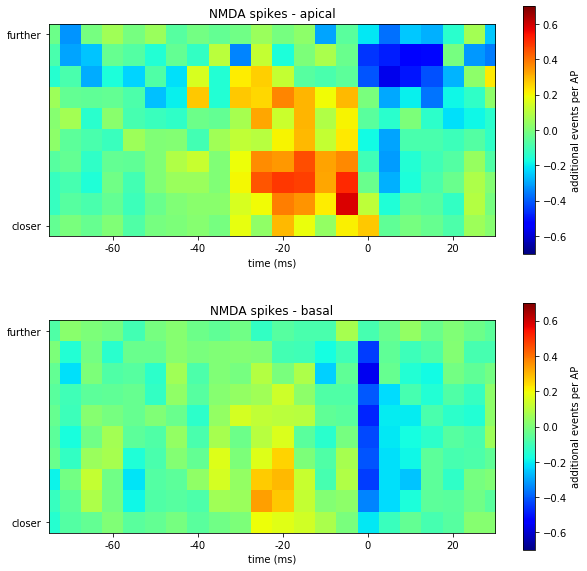

In [28]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('NMDA spikes - apical')
plt.imshow((nmda_apic-nmda_apic_rand)/len(spktimes),cmap='jet',vmin=-0.7,vmax=0.7)
plt.xticks(ticks=np.arange(0,26,4),labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlabel('time (ms)')
plt.xlim(5,26)

plt.subplot(2,1,2)
plt.title('NMDA spikes - basal')
plt.imshow((nmda_dend-nmda_dend_rand)/len(spktimes),cmap='jet', vmin=-0.7, vmax=0.7)
plt.xticks(ticks=np.arange(0,26,4),labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlim(5,26)

plt.xlabel('time (ms)')
plt.savefig('nmdaspikes.svg')
plt.show()

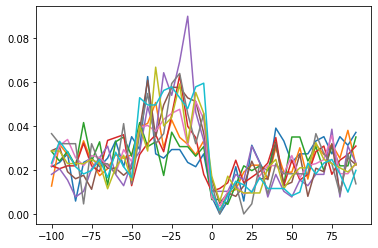

In [148]:
for i in np.arange(0,10):
    plt.plot(np.arange(-100,95,5),nmda_dend[i]/np.sum(nmda_dend[i]))


In [573]:
segs_conns[(segs_conns['Sec ID']==80) & (segs_conns.Type=='dend')]['Source Population'].value_counts()

dist_inh_stim    5
Name: Source Population, dtype: int64

(-150, 150)

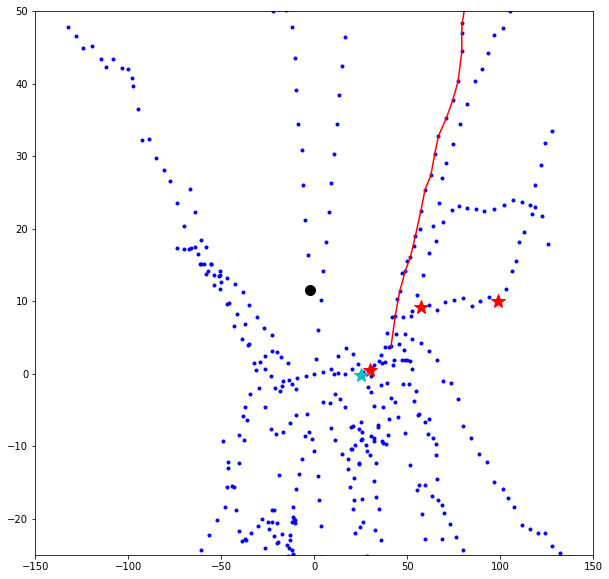

In [579]:
plt.figure(figsize=(10,10))
ind = 55
plt.plot(segs['Coord X'], segs['Coord Y'], 'b.')
plt.plot(segs.loc[0,'Coord X'], segs.loc[0,'Coord Y'], 'k.',markersize=20)

plt.plot(segs.loc[ind,'Coord X'], segs.loc[ind,'Coord Y'], 'r*',markersize=20)

for i in segs_conns[(segs_conns.Type=='dend')&(segs_conns['Sec ID']==2)]['Sec ID'].unique():
    plt.plot(segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord X'],
             segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord Y'],color='r')
    
#for i in segs_conns[(segs_conns.Type=='dend')&(segs_conns['Sec ID']==7)]['Sec ID'].unique():
#    plt.plot(segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord X'],
#             segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord Y'],color='c')
    
#plt.plot(segs[segs.segmentID==119]['Coord X'], segs[segs.segmentID==119]['Coord Y'],'r*',markersize=14)
#plt.plot(segs[segs.segmentID==110]['Coord X'], segs[segs.segmentID==110]['Coord Y'],'r*',markersize=14)
#plt.plot(segs[segs.segmentID==103]['Coord X'], segs[segs.segmentID==103]['Coord Y'],'r*',markersize=14)

#plt.plot(segs[segs.segmentID==134]['Coord X'], segs[segs.segmentID==134]['Coord Y'],'c*',markersize=14)
plt.ylim(-25,50)
plt.xlim(-150,150)

(526419, 527519)

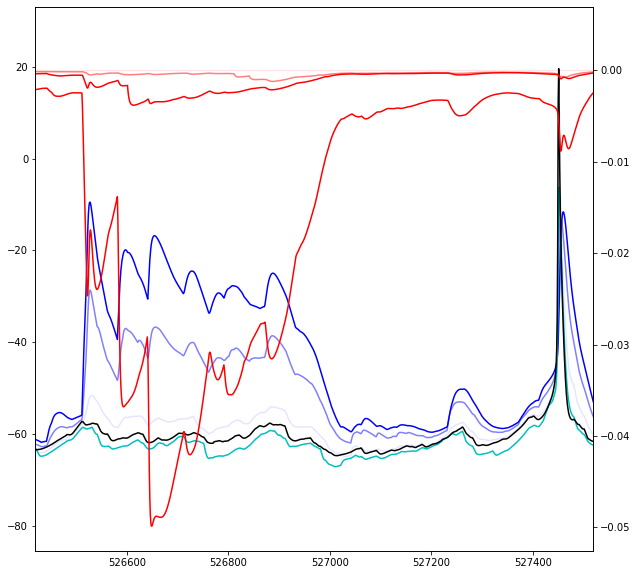

In [548]:
plt.figure(figsize=(10,10))
plt.plot(f['report']['biophysical']['data'][:,119],color='b')
plt.plot(f['report']['biophysical']['data'][:,110],color='b',alpha=0.5)
plt.plot(f['report']['biophysical']['data'][:,104],color='b',alpha=0.1)

plt.plot(f['report']['biophysical']['data'][:,134],color='c',alpha=1)
plt.plot(f['report']['biophysical']['data'][:,0],'k')
plt.twinx()
plt.plot(h['report']['biophysical']['data'][:,119],color='r')
plt.plot(h['report']['biophysical']['data'][:,110],color='r',alpha=0.5)
plt.plot(h['report']['biophysical']['data'][:,103],color='r',alpha=0.1)

plt.xlim(526519-100,526519+1000)

In [503]:
nmda2 = np.zeros((79,))

for i in spktimes:
    nmda_inds2 = np.sort(segs_nmda_df[(segs_nmda_df.Degrees<=3)&
             (~pd.isnull(segs_nmda_df.nmda_lower_bound))&
             (segs_nmda_df.mag<-0.1)&
                (segs_nmda_df.Type=='dend')]['nmda_lower_bound'].values.astype(int))

    x2, _ = np.histogram(nmda_inds2/10,bins=np.arange(i-40,i+40,1))
    nmda2 += x2
    
    #na_inds3 = segs_na_df[(segs_na_df.Degrees==3)&(~pd.isnull(segs_na_df.na_lower_bound))]['na_lower_bound'].values.astype(int)
    #x3, _ = np.histogram(na_inds3/10,bins=np.arange(i-20,i+20,1))
    #na3 += x3
    
    #na_inds4 = segs_na_df[(segs_na_df.Degrees==4)&(~pd.isnull(segs_na_df.na_lower_bound))]['na_lower_bound'].values.astype(int)
    #x4, _ = np.histogram(na_inds4/10,bins=np.arange(i-20,i+20,1))
    #na4 += x4
    
    #na_inds5 = segs_na_df[(segs_na_df.Degrees==5)&(~pd.isnull(segs_na_df.na_lower_bound))]['na_lower_bound'].values.astype(int)
    #x5, _ = np.histogram(na_inds5/10,bins=np.arange(i-20,i+20,1))
    #na5 += x5
    

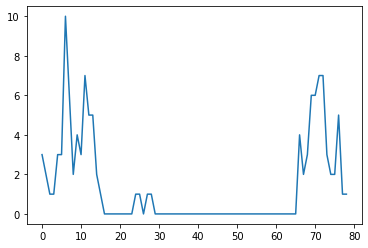

In [504]:
plt.plot(nmda2)

Text(0, 0.5, 'current (nA)')

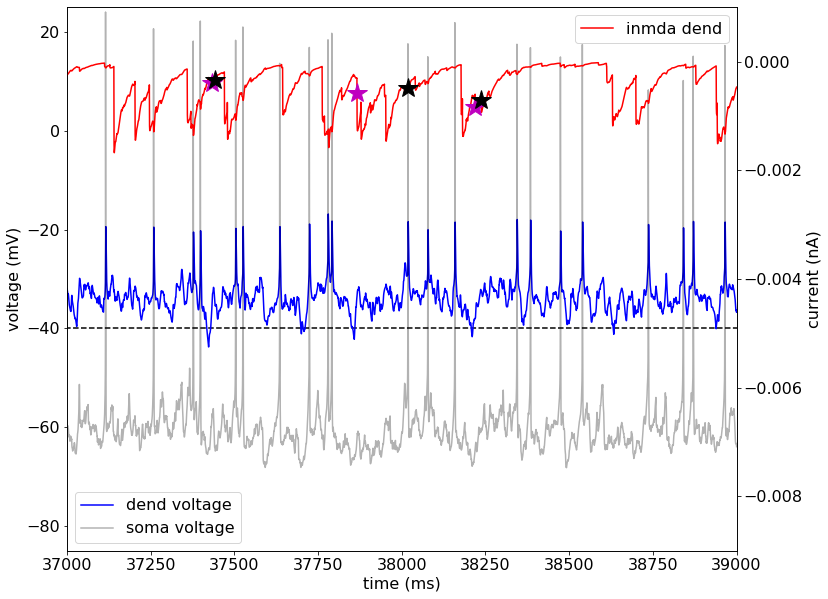

In [128]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

ind = 1139
plt.figure(figsize=(12,10))
plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,ind],color='b',label='dend voltage')
plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,0],color='k',alpha=0.3,label='soma voltage')
plt.legend(loc='lower left')
plt.hlines(-40,0,60000,linestyle='dashed')
plt.ylabel('voltage (mV)')
plt.ylim(-85,25)
plt.xlabel('time (ms)')
plt.twinx()
plt.plot(np.arange(0,60000,.1),h['report']['biophysical']['data'][:,ind],color='r',label='inmda dend')
plt.legend(loc='upper right')
plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==ind]['nmda_lower_bound'].values.astype(int)],
         h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==ind]['nmda_lower_bound'].values.astype(int),ind],'m*',markersize=20)
plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==ind]['nmda_upper_bound'].values.astype(int)],
         h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==ind]['nmda_upper_bound'].values.astype(int),ind],'k*',markersize=20)
plt.ylim(-0.009,0.001)
plt.xlim(37000,39000)
plt.ylabel('current (nA)')


Text(0, 0.5, 'current (nA)')

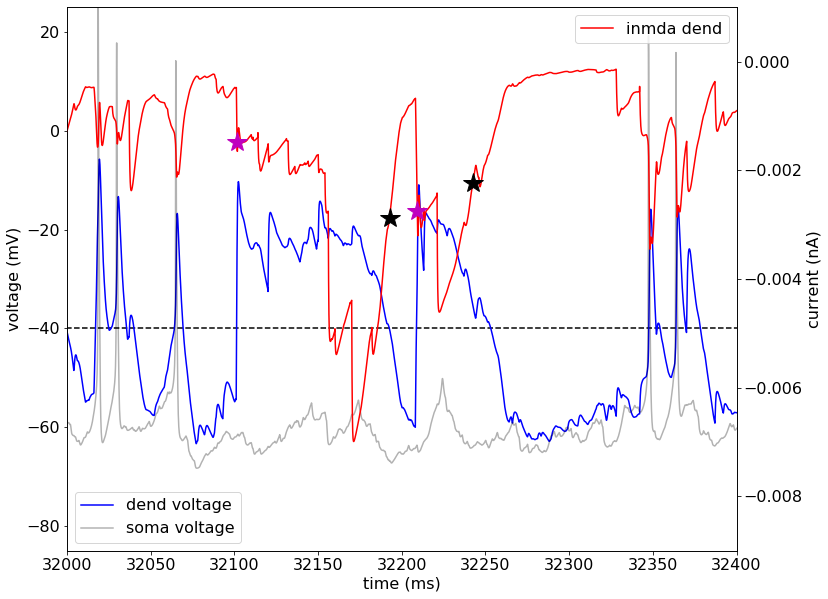

In [99]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

plt.figure(figsize=(12,10))
plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,175],color='b',label='dend voltage')
plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,0],color='k',alpha=0.3,label='soma voltage')
plt.legend(loc='lower left')
plt.hlines(-40,0,60000,linestyle='dashed')
plt.ylabel('voltage (mV)')
plt.ylim(-85,25)
plt.xlabel('time (ms)')
plt.twinx()
plt.plot(np.arange(0,60000,.1),h['report']['biophysical']['data'][:,175],color='r',label='inmda dend')
plt.legend(loc='upper right')
plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==175]['nmda_lower_bound'].values.astype(int)],
         h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==175]['nmda_lower_bound'].values.astype(int),175],'m*',markersize=20)
plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==175]['nmda_upper_bound'].values.astype(int)],
         h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==175]['nmda_upper_bound'].values.astype(int),175],'k*',markersize=20)
plt.xlim(32000,32400)
plt.ylim(-0.009,0.001)
plt.ylabel('current (nA)')


In [46]:
nmda_spktimes = nmda_df[nmda_df.mag<-0.1]['nmda_lower_bound']/10
n = np.zeros((12,))
for i in spktimes:
    x,y = np.histogram(nmda_spktimes[(nmda_spktimes>i-30) & (nmda_spktimes<i+30)]-i,bins=np.arange(-30,31,5))
    n+=x

In [44]:
np.arange(-30,31,5).shape

(13,)

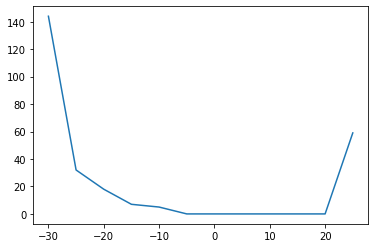

In [47]:
plt.plot(np.arange(-30,30,5),n)

In [26]:
na_spktimes = na_df[~pd.isnull(na_df.na_lower_bound)]['na_lower_bound']/10
na = np.zeros((20,))
for i in spktimes:
    x,y = np.histogram(na_spktimes[(na_spktimes>i-10) & (na_spktimes<i+10)]-i,bins=np.arange(-10,11,1))
    na+=x

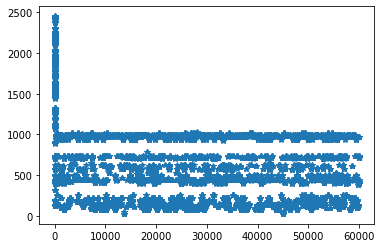

In [29]:
plt.plot(na_df[~pd.isnull(na_df.na_lower_bound)]['na_lower_bound']/10,
         na_df[~pd.isnull(na_df.na_lower_bound)]['seg_id'],'*')

NameError: name 'nmda_df' is not defined

NameError: name 'n' is not defined

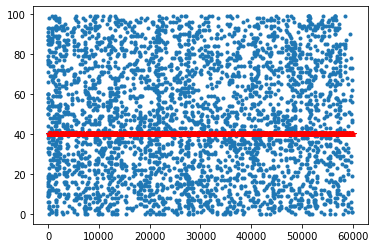

In [11]:
plt.plot(nmda_spktimes,np.random.randint(low=0,high=100,size=len(nmda_spktimes)),'.')
plt.plot(spktimes,np.tile(40,len(spktimes)),'r*')

In [396]:
x1,_=np.histogram(spktimes,bins=np.arange(0,10000,100))
x2,_=np.histogram(nmda_spktimes,bins=np.arange(0,10000,100))

(6000, 7000)

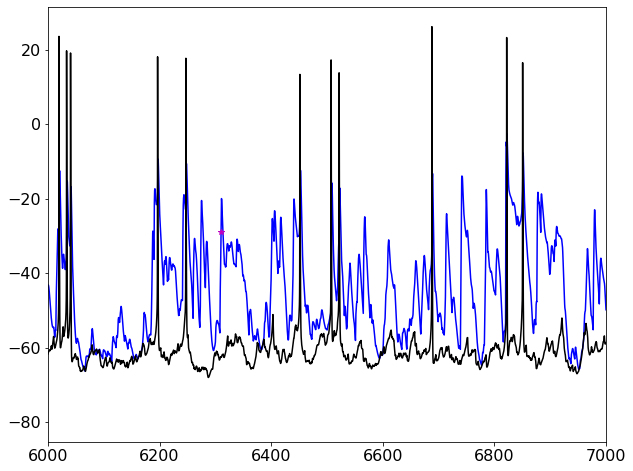

In [350]:
plt.figure(figsize=(10,8))
plt.plot(np.arange(0,10000,.1),control_v[:,176],color='b')
plt.plot(np.arange(0,10000,.1)[nmda_df.loc[nmda_df.seg_id==175,'nmda_lower_bound'].values.astype(int)],control_v[nmda_df.loc[nmda_df.seg_id==175,'nmda_lower_bound'].values.astype(int),176],'m*')
plt.plot(np.arange(0,10000,.1),control_v[:,0],color='k')
plt.xlim(6000,7000)

In [247]:
# ind1 = 3 sent to Drew
ind1 = 2
e1 = control_inmda[legit_uc_iso[ind1], p]
e2 = control_inmda[legit_dc_iso[ind1], p]
x30 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.3*e1, prepend=False))
x15 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.15*e1, prepend=False))

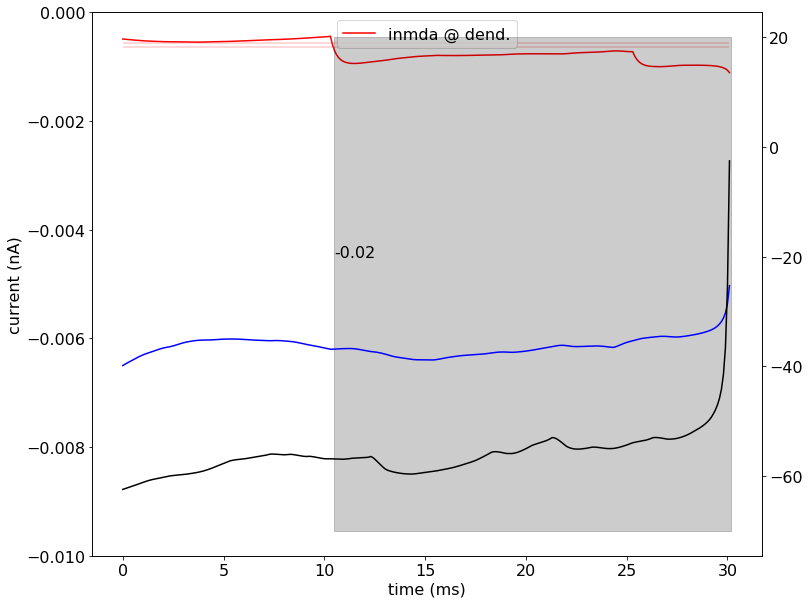

In [248]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

plt.figure(figsize=(12,10))
plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
         control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p],color='r',label='inmda @ dend.')
plt.hlines(1.3*e1,0,np.max(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1)),color='r',alpha=0.2)
plt.hlines(1.15*e1,0,np.max(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1)),color='r',alpha=0.2)
plt.ylabel('current (nA)')
plt.ylim(-0.010,0)
plt.legend(loc='upper center')
plt.xlabel('time (ms)')
plt.twinx()
plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
         control_v[legit_uc_iso[ind1]:legit_dc_iso[ind1],p],color='b',label='dend. volt.')
plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
         control_v[legit_uc_iso[ind1]:legit_dc_iso[ind1],0], color='k',label='soma volt.')


for i in np.arange(0,len(bounds)):
    plt.fill_between(np.array([bounds[i][0]/10,bounds[i][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
    plt.text(bounds[i][0]/10,-20-(i*10),'{x:.2f}'.format(x=sum_current[i]))
##plt.fill_between(np.array([bounds[1][0]/10,bounds[1][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
##plt.fill_between(np.array([bounds[2][0]/10,bounds[2][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
#plt.hlines(-40,0,np.max(np.arange(0,(legit_uc_iso[ind1+1]-legit_uc_iso[ind1])/10, 0.1)),linestyle='dashed')
##plt.text(1.5,14,'NMDA\nspike')
#plt.ylabel('voltage (mV)')
#plt.legend()

Text(0.5, 1.0, '[  842  1647  2619  3554  4403  4838  5367  6259  6906  7343  9697 12390\n 12773 13771 14890 15884 17077 18595 19939 22066 23737 24284 25413 26597\n 27044 28429 30164 30801 31385 32087 32916 33723 35481 36024 37321 38402\n 39508 39990 41964 42943 43622 44147 45706 46043 46602 47522 48410 48800\n 49997 50965 51281 52498 53049 53683 54313 56634 57005 57875 59693 62229\n 63190 64370 64795 66494 68097 68880 69584 70642 71213 72545 73268 74657\n 75841 77213 79503 80633 81032 82026 82994 84010 85540 86223 87097 88434\n 91288 93667 94914 95493 96901 98894 99324]')

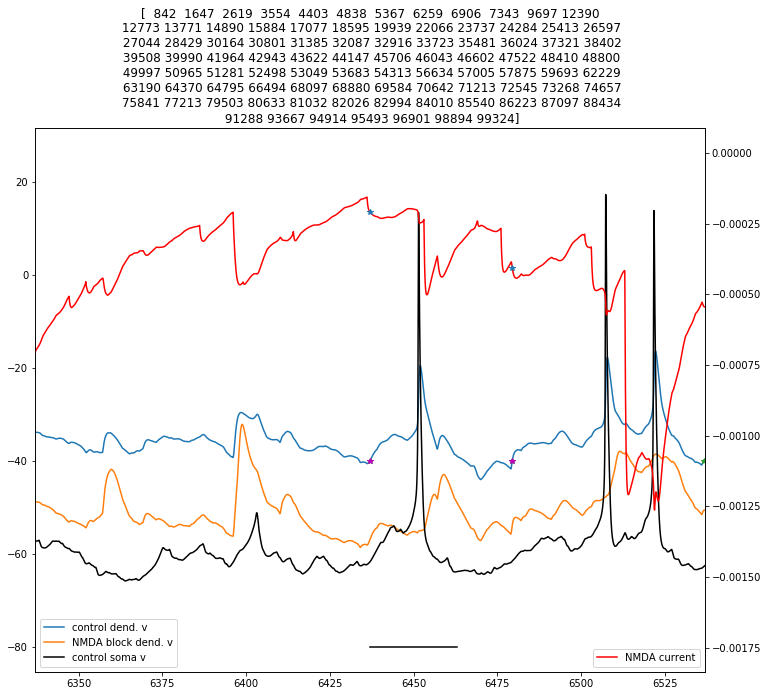

In [45]:
plt.figure(figsize=(12,10))
plt.plot(np.arange(0,10000,.1),control_v[:,p],label='control dend. v')
plt.plot(np.arange(0,10000,.1),NMDAblock_v[:,p],label='NMDA block dend. v')
plt.plot(np.arange(0,10000,.1),control_v[:,0],color='k',label='control soma v')

uc = voltage_criterion(control_v[:,p],-40)[0]


plt.plot(np.arange(0,10000,.1)[uc],control_v[uc,p],'*')
plt.plot(np.arange(0,10000,.1)[legit_uc],control_v[legit_uc,p],'m*')


center = np.floor(legit_uc[np.random.choice(np.arange(0,legit_uc.shape[0]))]/10)

plt.plot([center,center+26],[-80,-80],color='k')
plt.legend(loc='lower left')

plt.twinx()
plt.plot(np.arange(0,10000,.1),control_inmda[:,p],color='r',label='NMDA current')
plt.plot(np.arange(0,10000,.1)[legit_uc],control_inmda[legit_uc, p],'*')
#plt.plot(np.arange(0,10000,.1),control_gna[:,p],color='r',alpha=0.2, label='gNa')
plt.xlim(center-100,center+100)

plt.legend(loc='lower right')
plt.title('{}'.format(legit_uc))

(-65, 0)

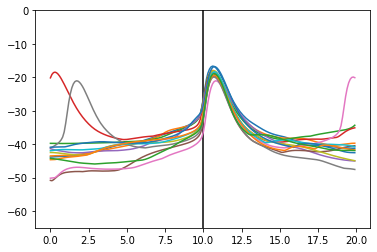

In [332]:
p = np.random.choice(segs[segs.Type=='apic'].index)
for i in spktimes:
    plt.plot(np.arange(0,20,.1), control_v[int(i*10)-100:int(i*10)+100,p])
plt.vlines(10,-65,0,color='k')
plt.ylim(-65,0)

No handles with labels found to put in legend.


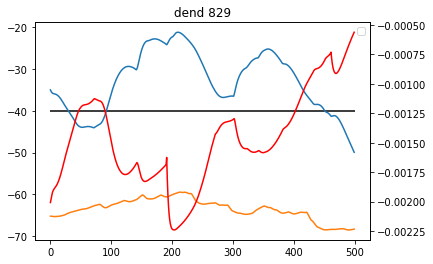

In [61]:
p = 829#np.random.choice(segs[segs.Type=='dend'].index)
plt.title('dend {}'.format(p))
plt.plot(control_v[7200:7700,p],label='dend')
plt.plot(control_v[7200:7700,0],label='soma')
plt.hlines(-40,0,500)
plt.twinx()
plt.plot(control_inmda[7200:7700,p],color='r')
plt.legend()

In [30]:
control_v[10000,0]

-64.93669985517535

(array([574., 247., 275., 347., 151., 246., 123., 100., 155., 308.]),
 array([-68.29374117, -61.6818314 , -55.06992164, -48.45801187,
        -41.8461021 , -35.23419233, -28.62228256, -22.01037279,
        -15.39846303,  -8.78655326,  -2.17464349]),
 <a list of 10 Patch objects>)

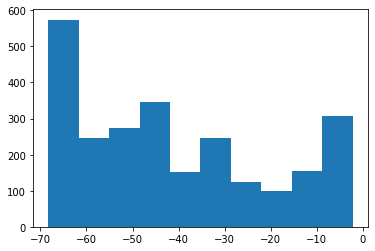

In [29]:
plt.hist(control_v[10000,:])

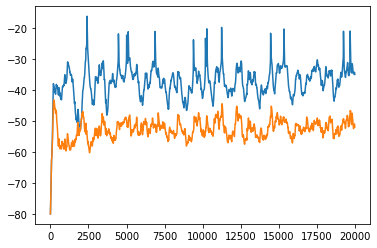

In [27]:
plt.plot(control_v[:,1200])
plt.plot(NMDAblock_v[:,1200])

In [16]:
df = ids_pos.set_index(['BMTK ID', 'X']).join(segs.set_index(['BMTK ID', 'X'])).reset_index()

In [17]:
df.loc[0,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[0]

(nan, -65.0773572393917)

In [18]:
df[(df.Distance>900) & (df.Distance<1000)]

Empty DataFrame
Columns: [BMTK ID, X, Type, Sec ID, Distance, Coord X, Coord Y, Coord Z]
Index: []

(1740, 1760)

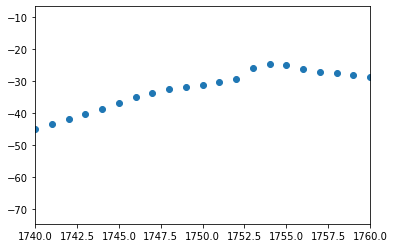

In [19]:
plt.scatter(np.arange(0,df.shape[0]), np.mean(f['report']['biophysical']['data'],axis=0))
plt.xlim(1740,1760)

Text(0, 0.5, 'mean potential of segment (mV)')

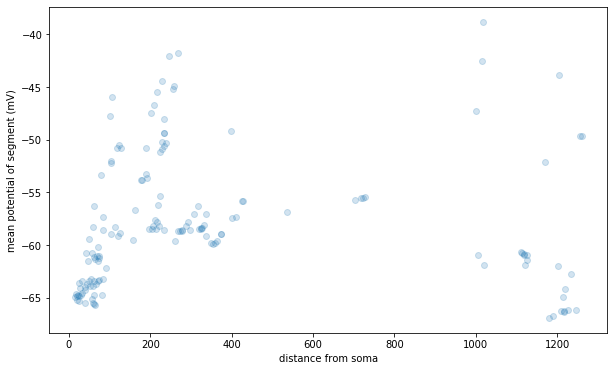

In [20]:
plt.figure(figsize=(10,6))
plt.scatter(df['Distance'],np.mean(f['report']['biophysical']['data'],axis=0),alpha=0.2)
plt.scatter(df.loc[0,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[0],color='r', marker='*', s=75)
plt.scatter(df.loc[1452,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[1452],color='m',marker='*', s=75)
plt.scatter(df.loc[1754,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[1754],color='k',marker='*', s=75)
plt.xlabel('distance from soma')
plt.ylabel('mean potential of segment (mV)')

Text(0, 0.5, 'membrane potential (mV)')

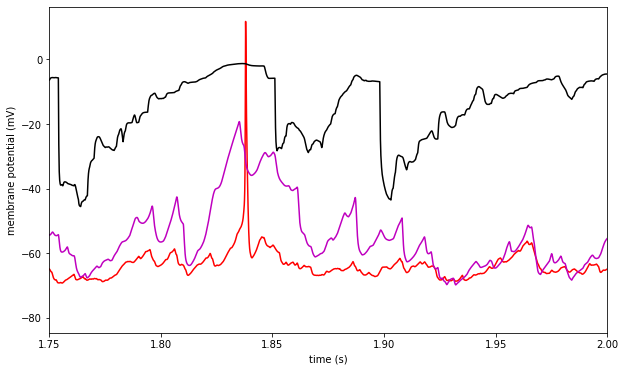

In [22]:
#plt.scatter(np.arange(0,f['report']['biophysical']['data'].shape[1]),np.mean(f['report']['biophysical']['data'],axis=0))

plt.figure(figsize=(10,6))

plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,0],color='r')
plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,1452],color='m')
plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,1754],color='k')
plt.xlim(1.75,2)
plt.xlabel('time (s)')
plt.ylabel('membrane potential (mV)')